### 뚝섬 한강 공원 주차장 분석

- 뚝섬 한강 공원의 주차장 혼잡도(여유, 보통, 혼잡, 만차)를 시간별로 예측
- 데이터 전처리, feature, taregt 선별 

In [11]:
# 세팅
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import missingno as msno  # nan 값 확인용
import holidays
from  sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [4]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")


------
## 데이터 보기

In [214]:
# 기본 데이터 불러오기
df=pd.read_csv('../../Data/한강공원 주차장 일별 이용 현황.csv', encoding='euc-kr')
df.head()


,지구별,주차장명,주차대수,이용시간,날짜
0,PLT-005,뚝섬1주차장,273,22891,2024/11/10
1,PLT-011,잠실1주차장,1059,66361,2024/11/10
2,PLT-001,강서1주차장,329,26875,2024/11/10
3,PLT-008,여의도5주차장,229,22509,2024/11/10
4,PLT-008,여의도2주차장,1934,150135,2024/11/10


In [215]:
# 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45277 entries, 0 to 45276
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지구별     45277 non-null  object
 1   주차장명    45277 non-null  object
 2   주차대수    45277 non-null  int64 
 3   이용시간    45277 non-null  int64 
 4   날짜      45277 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


> 주차장 일별 데이터 결측치 X

### 전체 데이터에서 뚝섬한강공원 데이터만 추출

In [216]:
df_dd = df[df['지구별'] == 'PLT-005']
df_dd.head()

,지구별,주차장명,주차대수,이용시간,날짜
0,PLT-005,뚝섬1주차장,273,22891,2024/11/10
10,PLT-005,뚝섬3주차장,686,62848,2024/11/10
16,PLT-005,뚝섬4주차장,864,79419,2024/11/10
21,PLT-005,뚝섬2주차장,965,108345,2024/11/10
30,PLT-005,뚝섬2주차장,850,91910,2024/11/09


In [217]:
# index 정리
df_dd.reset_index(drop=True, inplace=True)
df_dd.head()

,지구별,주차장명,주차대수,이용시간,날짜
0,PLT-005,뚝섬1주차장,273,22891,2024/11/10
1,PLT-005,뚝섬3주차장,686,62848,2024/11/10
2,PLT-005,뚝섬4주차장,864,79419,2024/11/10
3,PLT-005,뚝섬2주차장,965,108345,2024/11/10
4,PLT-005,뚝섬2주차장,850,91910,2024/11/09


In [218]:
df_dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지구별     6956 non-null   object
 1   주차장명    6956 non-null   object
 2   주차대수    6956 non-null   int64 
 3   이용시간    6956 non-null   int64 
 4   날짜      6956 non-null   object
dtypes: int64(2), object(3)
memory usage: 271.8+ KB


In [219]:
# 주차장 갯수 확인
# 1부터 4까지의 주차장 보유
df_dd['주차장명'].unique()

array(['뚝섬1주차장', '뚝섬3주차장', '뚝섬4주차장', '뚝섬2주차장'], dtype=object)

In [220]:
# 이용시간 0값 확인
df_dd.describe()

,주차대수,이용시간
count,6956.000000,6956.000000
mean,526.861415,52692.554198
std,350.742185,41924.445747
min,1.000000,0.000000
25%,250.000000,19991.000000
50%,460.000000,44253.000000
75%,702.000000,71251.750000
max,2999.000000,291616.000000


In [221]:

df_dd[df_dd['이용시간'] == 0].sort_values('주차장명')

,지구별,주차장명,주차대수,이용시간,날짜
4002,PLT-005,뚝섬1주차장,135,0,2022/02/06
6167,PLT-005,뚝섬1주차장,2,0,2020/08/12
6169,PLT-005,뚝섬1주차장,2,0,2020/08/11
4004,PLT-005,뚝섬2주차장,346,0,2022/02/06
4001,PLT-005,뚝섬3주차장,188,0,2022/02/06
6165,PLT-005,뚝섬3주차장,6,0,2020/08/12
6168,PLT-005,뚝섬3주차장,4,0,2020/08/11
6180,PLT-005,뚝섬3주차장,2,0,2020/08/07
4003,PLT-005,뚝섬4주차장,292,0,2022/02/06
6181,PLT-005,뚝섬4주차장,1,0,2020/08/06


> 주차대수는 있지만 이용시간이 0으로 작성된 것을 확인

#### 0값을 월 & (요일) & 주차장명 & 년도 별 1대당 평균 이용시간으로 대치

In [222]:
# 날짜를 datetime 으로 변경
df_dd['날짜']=pd.to_datetime(df_dd['날짜'])

In [223]:
# 날짜를 년도, 월, 일로 구분
df_dd['년도'] = df_dd['날짜'].dt.year
df_dd['월'] = df_dd['날짜'].dt.month
df_dd['일'] = df_dd['날짜'].dt.day

In [224]:
df_dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지구별     6956 non-null   object        
 1   주차장명    6956 non-null   object        
 2   주차대수    6956 non-null   int64         
 3   이용시간    6956 non-null   int64         
 4   날짜      6956 non-null   datetime64[ns]
 5   년도      6956 non-null   int32         
 6   월       6956 non-null   int32         
 7   일       6956 non-null   int32         
dtypes: datetime64[ns](1), int32(3), int64(2), object(2)
memory usage: 353.4+ KB


In [620]:
# 날짜로 평일, 휴일, 주말 구분
# 평일 휴일로 분리 시켜주기 

# 대한민국 공휴일 가져오기
kr_holidays = holidays.KR(years=range(2020,2025))

# 날짜가 공휴일인지를 체크하는 함수 추가
df_dd['휴일여부'] = df_dd['날짜'].apply(lambda x: '휴일' if x in kr_holidays else ('주말' if x.weekday() >= 5 else '평일'))
df_dd.head()

,지구별,주차장명,주차대수,이용시간,날짜,년도,월,일,휴일여부,1대당 평균 주차시간
0,PLT-005,뚝섬1주차장,273,22891.0,2024-11-10,2024,11,10,주말,83.849817
1,PLT-005,뚝섬3주차장,686,62848.0,2024-11-10,2024,11,10,주말,91.615160
2,PLT-005,뚝섬4주차장,864,79419.0,2024-11-10,2024,11,10,주말,91.920139
3,PLT-005,뚝섬2주차장,965,108345.0,2024-11-10,2024,11,10,주말,112.274611
4,PLT-005,뚝섬2주차장,850,91910.0,2024-11-09,2024,11,9,주말,108.129412


In [226]:
df_dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지구별     6956 non-null   object        
 1   주차장명    6956 non-null   object        
 2   주차대수    6956 non-null   int64         
 3   이용시간    6956 non-null   int64         
 4   날짜      6956 non-null   datetime64[ns]
 5   년도      6956 non-null   int32         
 6   월       6956 non-null   int32         
 7   일       6956 non-null   int32         
 8   휴일여부    6956 non-null   object        
dtypes: datetime64[ns](1), int32(3), int64(2), object(3)
memory usage: 407.7+ KB


In [227]:
# 계산에 포함하지 않기 위해 nan 값으로 대치
df_dd['이용시간'].replace(0, np.nan, inplace= True)

In [228]:
# 각 일자별 1대당 평균 주차시간 컬럼 추가
df_dd['1대당 평균 주차시간']=df_dd['이용시간']/df_dd['주차대수']

In [229]:
df_dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   지구별          6956 non-null   object        
 1   주차장명         6956 non-null   object        
 2   주차대수         6956 non-null   int64         
 3   이용시간         6945 non-null   float64       
 4   날짜           6956 non-null   datetime64[ns]
 5   년도           6956 non-null   int32         
 6   월            6956 non-null   int32         
 7   일            6956 non-null   int32         
 8   휴일여부         6956 non-null   object        
 9   1대당 평균 주차시간  6945 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int32(3), int64(1), object(3)
memory usage: 462.1+ KB


In [230]:
df_dd[df_dd['이용시간'].isna()].sort_values('주차장명')

,지구별,주차장명,주차대수,이용시간,날짜,년도,월,일,휴일여부,1대당 평균 주차시간
4002,PLT-005,뚝섬1주차장,135,NaN,2022-02-06,2022,2,6,주말,NaN
6167,PLT-005,뚝섬1주차장,2,NaN,2020-08-12,2020,8,12,평일,NaN
6169,PLT-005,뚝섬1주차장,2,NaN,2020-08-11,2020,8,11,평일,NaN
4004,PLT-005,뚝섬2주차장,346,NaN,2022-02-06,2022,2,6,주말,NaN
4001,PLT-005,뚝섬3주차장,188,NaN,2022-02-06,2022,2,6,주말,NaN
6165,PLT-005,뚝섬3주차장,6,NaN,2020-08-12,2020,8,12,평일,NaN
6168,PLT-005,뚝섬3주차장,4,NaN,2020-08-11,2020,8,11,평일,NaN
6180,PLT-005,뚝섬3주차장,2,NaN,2020-08-07,2020,8,7,평일,NaN
4003,PLT-005,뚝섬4주차장,292,NaN,2022-02-06,2022,2,6,주말,NaN
6181,PLT-005,뚝섬4주차장,1,NaN,2020-08-06,2020,8,6,평일,NaN


In [231]:
# 주차장명, 년도, 월, 휴일여부에 따른 1대당 평균 주차시간 nan 값 대치


df_dd_timemean =df_dd.groupby(['주차장명','년도','월','휴일여부'])['1대당 평균 주차시간'].mean()

In [232]:
df_dd_timemean

주차장명    년도    월   휴일여부
뚝섬1주차장  2020  1   평일      334.780844
                  휴일      148.613149
              2   주말      225.680606
                  평일      225.369356
              3   주말      148.127413
                             ...    
뚝섬4주차장  2024  10  주말      107.913836
                  평일      112.224391
                  휴일      113.898011
              11  주말      103.052425
                  평일      107.537074
Name: 1대당 평균 주차시간, Length: 641, dtype: float64

In [233]:
df_dd_timemean.index = pd.MultiIndex.from_tuples(df_dd_timemean.index, names=['주차장명', '년도', '월', '휴일여부'])

#  # 주차장명, 년도, 월, 휴일여부에 따른 1대당 평균 주차시간 값과 일치하는 항목 대치 해주는 함수
def map_avg_parking_time(row):
    try:
        return df_dd_timemean.loc[(row['주차장명'], row['년도'], row['월'], row['휴일여부'])]
    except KeyError:
        return None

df_nan = df_dd['1대당 평균 주차시간'].isna()
df_dd.loc[df_nan, '1대당 평균 주차시간'] = df_dd[df_nan].apply(map_avg_parking_time, axis=1)

df_dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   지구별          6956 non-null   object        
 1   주차장명         6956 non-null   object        
 2   주차대수         6956 non-null   int64         
 3   이용시간         6945 non-null   float64       
 4   날짜           6956 non-null   datetime64[ns]
 5   년도           6956 non-null   int32         
 6   월            6956 non-null   int32         
 7   일            6956 non-null   int32         
 8   휴일여부         6956 non-null   object        
 9   1대당 평균 주차시간  6956 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int32(3), int64(1), object(3)
memory usage: 462.1+ KB


In [234]:
df_dd

,지구별,주차장명,주차대수,이용시간,날짜,년도,월,일,휴일여부,1대당 평균 주차시간
0,PLT-005,뚝섬1주차장,273,22891.0,2024-11-10,2024,11,10,주말,83.849817
1,PLT-005,뚝섬3주차장,686,62848.0,2024-11-10,2024,11,10,주말,91.615160
2,PLT-005,뚝섬4주차장,864,79419.0,2024-11-10,2024,11,10,주말,91.920139
3,PLT-005,뚝섬2주차장,965,108345.0,2024-11-10,2024,11,10,주말,112.274611
4,PLT-005,뚝섬2주차장,850,91910.0,2024-11-09,2024,11,9,주말,108.129412
...,...,...,...,...,...,...,...,...,...,...
6951,PLT-005,뚝섬2주차장,127,30987.0,2020-01-21,2020,1,21,평일,243.992126
6952,PLT-005,뚝섬3주차장,58,1468.0,2020-01-20,2020,1,20,평일,25.310345
6953,PLT-005,뚝섬3주차장,242,14229.0,2020-01-19,2020,1,19,주말,58.797521
6954,PLT-005,뚝섬3주차장,253,18191.0,2020-01-18,2020,1,18,주말,71.901186


In [235]:
# 이용시간의 nan값을 1대당 평균 주차시간을 1대당 평균 주차시간을 이용해 대치하자
df_dd['이용시간'].fillna((df_dd['주차대수']*df_dd['1대당 평균 주차시간']),inplace=True)

In [236]:
df_dd[df_dd['주차대수'] ==2 ]


,지구별,주차장명,주차대수,이용시간,날짜,년도,월,일,휴일여부,1대당 평균 주차시간
1930,PLT-005,뚝섬2주차장,2,242.000000,2023-07-15,2023,7,15,주말,121.000000
3268,PLT-005,뚝섬3주차장,2,98.000000,2022-08-09,2022,8,9,평일,49.000000
6167,PLT-005,뚝섬1주차장,2,175.106827,2020-08-12,2020,8,12,평일,87.553414
6169,PLT-005,뚝섬1주차장,2,175.106827,2020-08-11,2020,8,11,평일,87.553414
6180,PLT-005,뚝섬3주차장,2,130.907187,2020-08-07,2020,8,7,평일,65.453593


> 이용시간의 0값을 -> nan 으로 변경후           
1대당 평균 주차시간을 구해서 주차장명, 년, 월, 휴일여부에 따른 주차시간 평균 * 주차대수로 대치함


In [237]:
df_dd[df_dd['년도'] == 2024]

,지구별,주차장명,주차대수,이용시간,날짜,년도,월,일,휴일여부,1대당 평균 주차시간
0,PLT-005,뚝섬1주차장,273,22891.0,2024-11-10,2024,11,10,주말,83.849817
1,PLT-005,뚝섬3주차장,686,62848.0,2024-11-10,2024,11,10,주말,91.615160
2,PLT-005,뚝섬4주차장,864,79419.0,2024-11-10,2024,11,10,주말,91.920139
3,PLT-005,뚝섬2주차장,965,108345.0,2024-11-10,2024,11,10,주말,112.274611
4,PLT-005,뚝섬2주차장,850,91910.0,2024-11-09,2024,11,9,주말,108.129412
...,...,...,...,...,...,...,...,...,...,...
1251,PLT-005,뚝섬4주차장,390,32945.0,2024-01-02,2024,1,2,평일,84.474359
1252,PLT-005,뚝섬2주차장,1025,99643.0,2024-01-01,2024,1,1,휴일,97.212683
1253,PLT-005,뚝섬1주차장,252,14710.0,2024-01-01,2024,1,1,휴일,58.373016
1254,PLT-005,뚝섬3주차장,718,69321.0,2024-01-01,2024,1,1,휴일,96.547354


In [238]:
# df_dd.to_csv('../../Data/뚝섬일별데이터.csv',index=False)

-------
### 날씨 + 주차장 일별 데이터

In [336]:
df_weather=pd.read_csv('../../Data/뚝섬주차장+날씨+휴무일.csv')

In [337]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   지구별            5940 non-null   object 
 1   주차장명           5940 non-null   object 
 2   주차대수           5940 non-null   int64  
 3   이용시간           5940 non-null   float64
 4   날짜             5940 non-null   object 
 5   년도             5940 non-null   int64  
 6   월              5940 non-null   int64  
 7   일              5940 non-null   int64  
 8   휴일여부           5940 non-null   int64  
 9   1대당 평균 주차시간    5940 non-null   float64
 10  평균기온           5940 non-null   float64
 11  최저기온           5936 non-null   float64
 12  최저기온 시각(hhmi)  5936 non-null   float64
 13  최고기온           5940 non-null   float64
 14  최고기온 시각(hhmi)  5940 non-null   int64  
 15  평균 상대습도(%)     5940 non-null   float64
dtypes: float64(7), int64(6), object(3)
memory usage: 742.6+ KB


In [376]:
# 날짜 컬럼 타입 변경
df_weather['날짜'] = pd.to_datetime(df_weather['날짜'])

In [341]:
df_weather

,지구별,주차장명,주차대수,이용시간,날짜,년도,월,일,휴일여부,1대당 평균 주차시간,평균기온,최저기온,최저기온 시각(hhmi),최고기온,최고기온 시각(hhmi),평균 상대습도(%)
0,PLT-005,뚝섬2주차장,518,54850.0,2024-02-29,2024,2,29,0,105.888031,4.8,0.3,2400.0,9.6,1539,63.6
1,PLT-005,뚝섬1주차장,175,10098.0,2024-02-29,2024,2,29,0,57.702857,4.8,0.3,2400.0,9.6,1539,63.6
2,PLT-005,뚝섬3주차장,260,20227.0,2024-02-29,2024,2,29,0,77.796154,4.8,0.3,2400.0,9.6,1539,63.6
3,PLT-005,뚝섬4주차장,526,54791.0,2024-02-29,2024,2,29,0,104.165399,4.8,0.3,2400.0,9.6,1539,63.6
4,PLT-005,뚝섬3주차장,195,17464.0,2024-02-28,2024,2,28,0,89.558974,6.4,3.2,712.0,10.1,1509,59.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,PLT-005,뚝섬2주차장,127,30987.0,2020-01-21,2020,1,21,0,243.992126,-0.4,-5.6,800.0,5.5,1541,36.9
5936,PLT-005,뚝섬3주차장,58,1468.0,2020-01-20,2020,1,20,0,25.310345,0.7,-3.3,2324.0,5.5,1313,46.8
5937,PLT-005,뚝섬3주차장,242,14229.0,2020-01-19,2020,1,19,1,58.797521,1.9,-0.4,3.0,5.3,1510,62.8
5938,PLT-005,뚝섬3주차장,253,18191.0,2020-01-18,2020,1,18,1,71.901186,0.3,-4.1,802.0,5.9,1503,48.1


In [ ]:
df[df_weather['최저기온'].isna()]

,지구별,주차장명,주차대수,이용시간,날짜,년도,월,일,휴일여부,1대당 평균 주차시간,평균기온,최저기온,최저기온 시각(hhmi),최고기온,최고기온 시각(hhmi),평균 상대습도(%)
2253,PLT-005,뚝섬2주차장,344,47871.0,2022-08-08,2022,8,8,0,139.159884,26.8,NaN,NaN,28.4,1,91.6
2254,PLT-005,뚝섬1주차장,104,7250.0,2022-08-08,2022,8,8,0,69.711538,26.8,NaN,NaN,28.4,1,91.6
2255,PLT-005,뚝섬4주차장,303,34180.0,2022-08-08,2022,8,8,0,112.805281,26.8,NaN,NaN,28.4,1,91.6
2256,PLT-005,뚝섬3주차장,182,23097.0,2022-08-08,2022,8,8,0,126.906593,26.8,NaN,NaN,28.4,1,91.6


> 최저기온, 최저기온 시각에 결측치 있음           
> 검색을 통해 당시 정보 얻음  
> 20220808 서울 날씨 최저기온 24도, 최저기온시각 13시, 14시

In [342]:
# 얻은 정보로 결측치 대치
df_weather['최저기온'].fillna(24, inplace=True)
df_weather['최저기온 시각(hhmi)'].fillna(1300.0, inplace=True)


In [343]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   지구별            5940 non-null   object 
 1   주차장명           5940 non-null   object 
 2   주차대수           5940 non-null   int64  
 3   이용시간           5940 non-null   float64
 4   날짜             5940 non-null   object 
 5   년도             5940 non-null   int64  
 6   월              5940 non-null   int64  
 7   일              5940 non-null   int64  
 8   휴일여부           5940 non-null   int64  
 9   1대당 평균 주차시간    5940 non-null   float64
 10  평균기온           5940 non-null   float64
 11  최저기온           5940 non-null   float64
 12  최저기온 시각(hhmi)  5940 non-null   float64
 13  최고기온           5940 non-null   float64
 14  최고기온 시각(hhmi)  5940 non-null   int64  
 15  평균 상대습도(%)     5940 non-null   float64
dtypes: float64(7), int64(6), object(3)
memory usage: 742.6+ KB


In [344]:
# 평균기온 범주화
temp_min = df_weather['평균기온'].min()
temp_max = df_weather['평균기온'].max()

print(temp_max, temp_min)
bins=np.arange(np.floor(temp_min), np.ceil(temp_max) + 5, 5)

df_weather['평균온도 구분'] = pd.cut(df_weather['평균기온'], bins=bins,labels =[-15,-10,-5,0,5,10,15,20,25,30],include_lowest=True)

31.7 -14.9


In [345]:
temp_min = df_weather['최고기온'].min()
temp_max = df_weather['최고기온'].max()

print(temp_max, temp_min)
bins=np.arange(np.floor(temp_min), np.ceil(temp_max) + 5, 5)

df_weather['최고기온 구분'] = pd.cut(df_weather['최고기온'], bins=bins,labels =[-11,-6,-1,4,9,14,19,24,29,34],include_lowest=True)

36.5 -10.7


In [346]:
temp_min = df_weather['최저기온'].min()
temp_max = df_weather['최저기온'].max()

print(temp_max, temp_min)
bins=np.arange(np.floor(temp_min), np.ceil(temp_max) + 5, 5)
bins
df_weather['최저기온 구분'] = pd.cut(df_weather['최저기온'], bins=bins,labels =[-19,-14,-9,-4,1,6,11,16,21,26],include_lowest=True)

27.8 -18.6


In [363]:
df_weather.columns

Index(['지구별', '주차장명', '주차대수', '이용시간', '날짜', '년도', '월', '일', '휴일여부',
       '1대당 평균 주차시간', '평균기온', '최저기온', '최저기온 시각(hhmi)', '최고기온', '최고기온 시각(hhmi)',
       '평균 상대습도(%)', '평균온도 구분', '최고기온 구분', '최저기온 구분'],
      dtype='object')

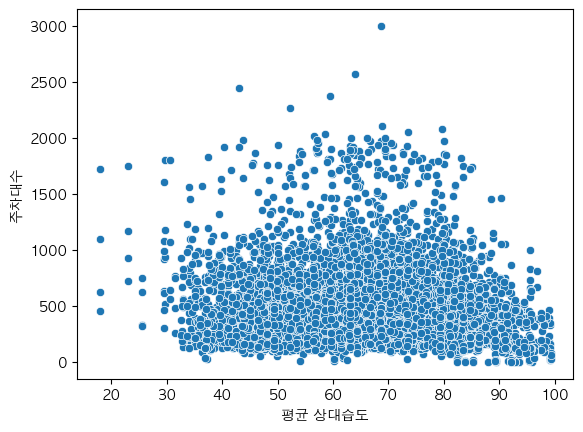

In [365]:
sns.scatterplot(
    x='평균 상대습도(%)',
    y='주차대수',
    # hue='휴일여부',
    data=df_weather
)
plt.ylabel('주차대수')
plt.xlabel('평균 상대습도')

plt.show()

> 습도는 필요 없음

In [1]:
plt.figure(figsize=(20,20))
sns.swarmplot(
    x='월',
    y='주차대수',
    data=df_weather,
)

plt.ylabel('주차대수')
plt.xlabel('월')

plt.show()

NameError: name 'plt' is not defined

--------------
## 온도 그래프

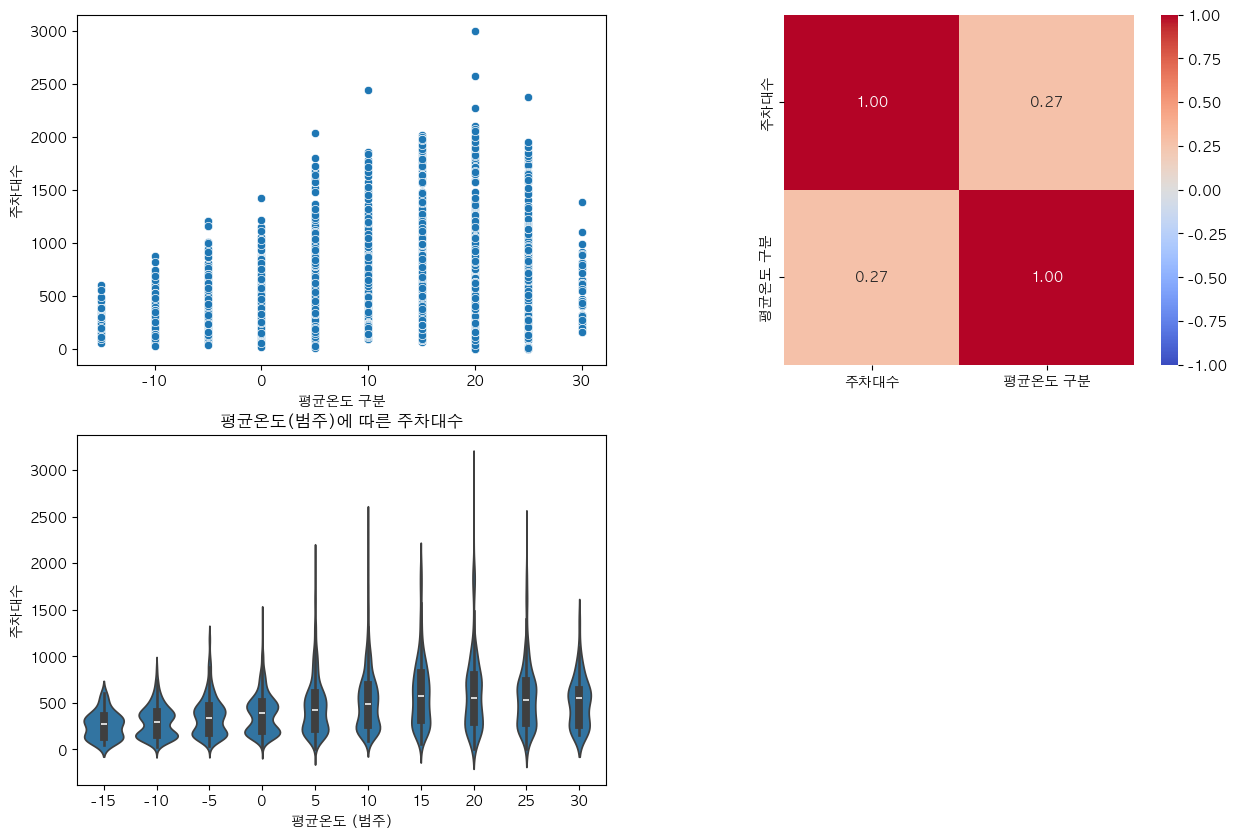

In [360]:
fig = plt.figure(figsize=(15,10))
ax1= fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

sns.scatterplot(
    x='평균온도 구분',
    y='주차대수',
    data=df_weather,
    ax = ax1
)


sns.heatmap(df_weather[['주차대수','평균온도 구분']].corr(), 
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ax=ax2
            ) 

sns.violinplot(
    y='주차대수',
    x='평균온도 구분',
    # hue='휴일여부',
    data= df_weather,
    ax=ax3
)
plt.xlabel('평균온도 (범주)')
plt.ylabel('주차대수')
plt.title('평균온도(범주)에 따른 주차대수')
plt.show()

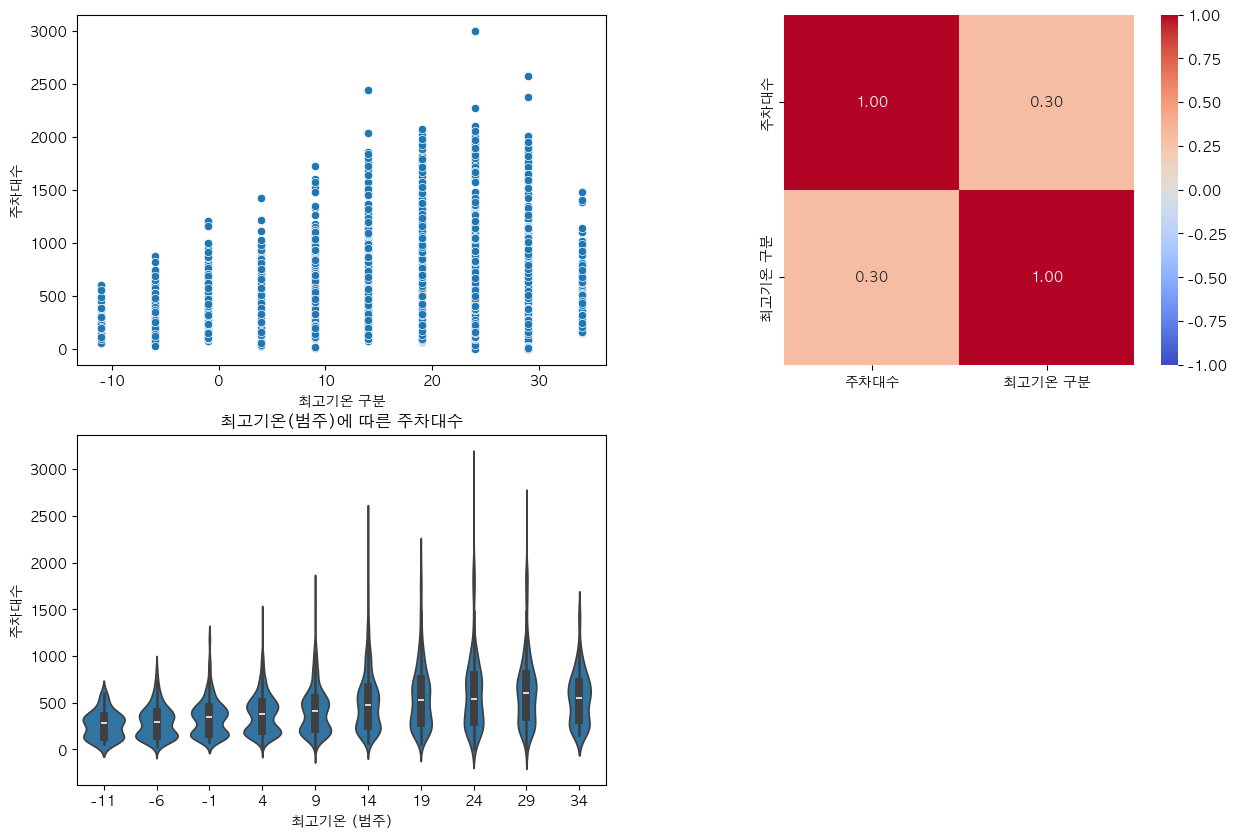

In [358]:

fig = plt.figure(figsize=(15,10))
ax1= fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

sns.scatterplot(
    x='최고기온 구분',
    y='주차대수',
    data=df_weather,
    ax = ax1
)
sns.heatmap(df_weather[['주차대수','최고기온 구분']].corr(), 
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ax=ax2
            ) 

sns.violinplot(
    x='최고기온 구분',
    y='주차대수',
    data=df_weather,
    ax = ax3
)


plt.xlabel('최고기온 (범주)')
plt.ylabel('주차대수')
plt.title('최고기온(범주)에 따른 주차대수')
plt.show()

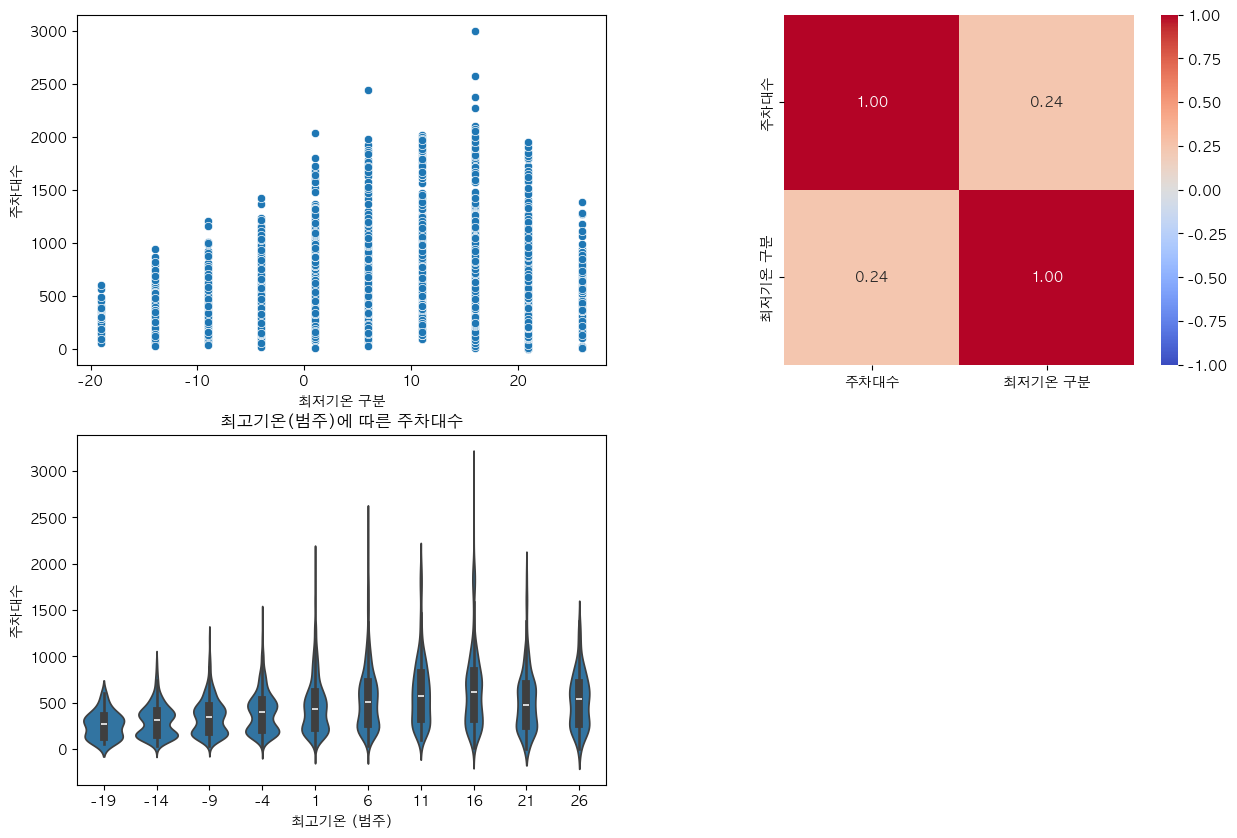

In [ ]:

fig = plt.figure(figsize=(15,10))
ax1= fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

sns.scatterplot(
    x='최저기온 구분',
    y='주차대수',
    data=df_weather,
    ax = ax1
)
sns.heatmap(df_weather[['주차대수','최저기온 구분']].corr(), 
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ax=ax2
            ) 

sns.violinplot(
    x='최저기온 구분',
    y='주차대수',
    data=df_weather,
    ax = ax3
)


plt.xlabel('최저기온 (범주)')
plt.ylabel('주차대수')
plt.title('최저기온(범주)에 따른 주차대수')
plt.show()

> 평균기온, 최고기온, 최저기온은 쓸만하다

NameError: name 'df_weather' is not defined

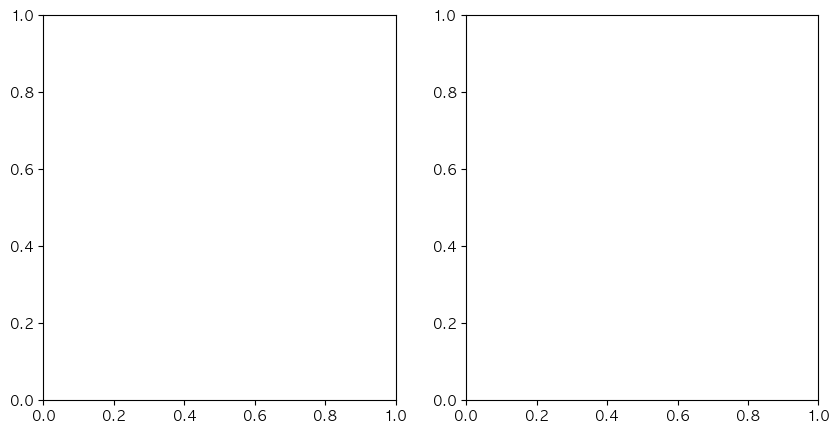

In [ ]:

fig = plt.figure(figsize=(10,5))
ax1= fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sns.heatmap(df_weather[['주차대수','휴일여부']].corr(), 
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            ax=ax1
            )

# sns.swarmplot(
#     x='휴일여부',
#     y='주차대수',
#     data=df_weather,
#     ax=ax2
# )



> 휴일여부는 사용해야함

--------
### 교통량 데이터로 일별 주차대수를 아침, 점심, 저녁으로 나누기

In [473]:
df_traffic=pd.read_csv('../../Data/combined_data_filtered.csv')
df_traffic.head()

,지점명,일자,방향,0시,1시,2시,3시,4시,5시,6시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,영동대교,20220301,유입,1109.0,784.0,579.0,395.0,361.0,516.0,773.0,...,2582.0,2614.0,2864.0,2677.0,2368.0,2260.0,2080.0,1893.0,1724.0,994.0
1,영동대교,20220302,유입,705.0,529.0,329.0,289.0,317.0,681.0,1239.0,...,3271.0,3340.0,4125.0,4203.0,3918.0,3783.0,2879.0,2820.0,2709.0,1470.0
2,영동대교,20220303,유입,1075.0,759.0,609.0,418.0,424.0,705.0,1212.0,...,3287.0,3458.0,4123.0,4323.0,3985.0,3701.0,2794.0,3068.0,2858.0,1540.0
3,영동대교,20220304,유입,1116.0,804.0,633.0,477.0,463.0,744.0,1336.0,...,3325.0,3683.0,4032.0,3954.0,3824.0,3473.0,3101.0,2983.0,3006.0,1572.0
4,영동대교,20220305,유입,1180.0,808.0,679.0,518.0,463.0,655.0,1014.0,...,3402.0,3597.0,4268.0,3818.0,3259.0,2644.0,2405.0,2225.0,2186.0,1351.0


<Axes: >

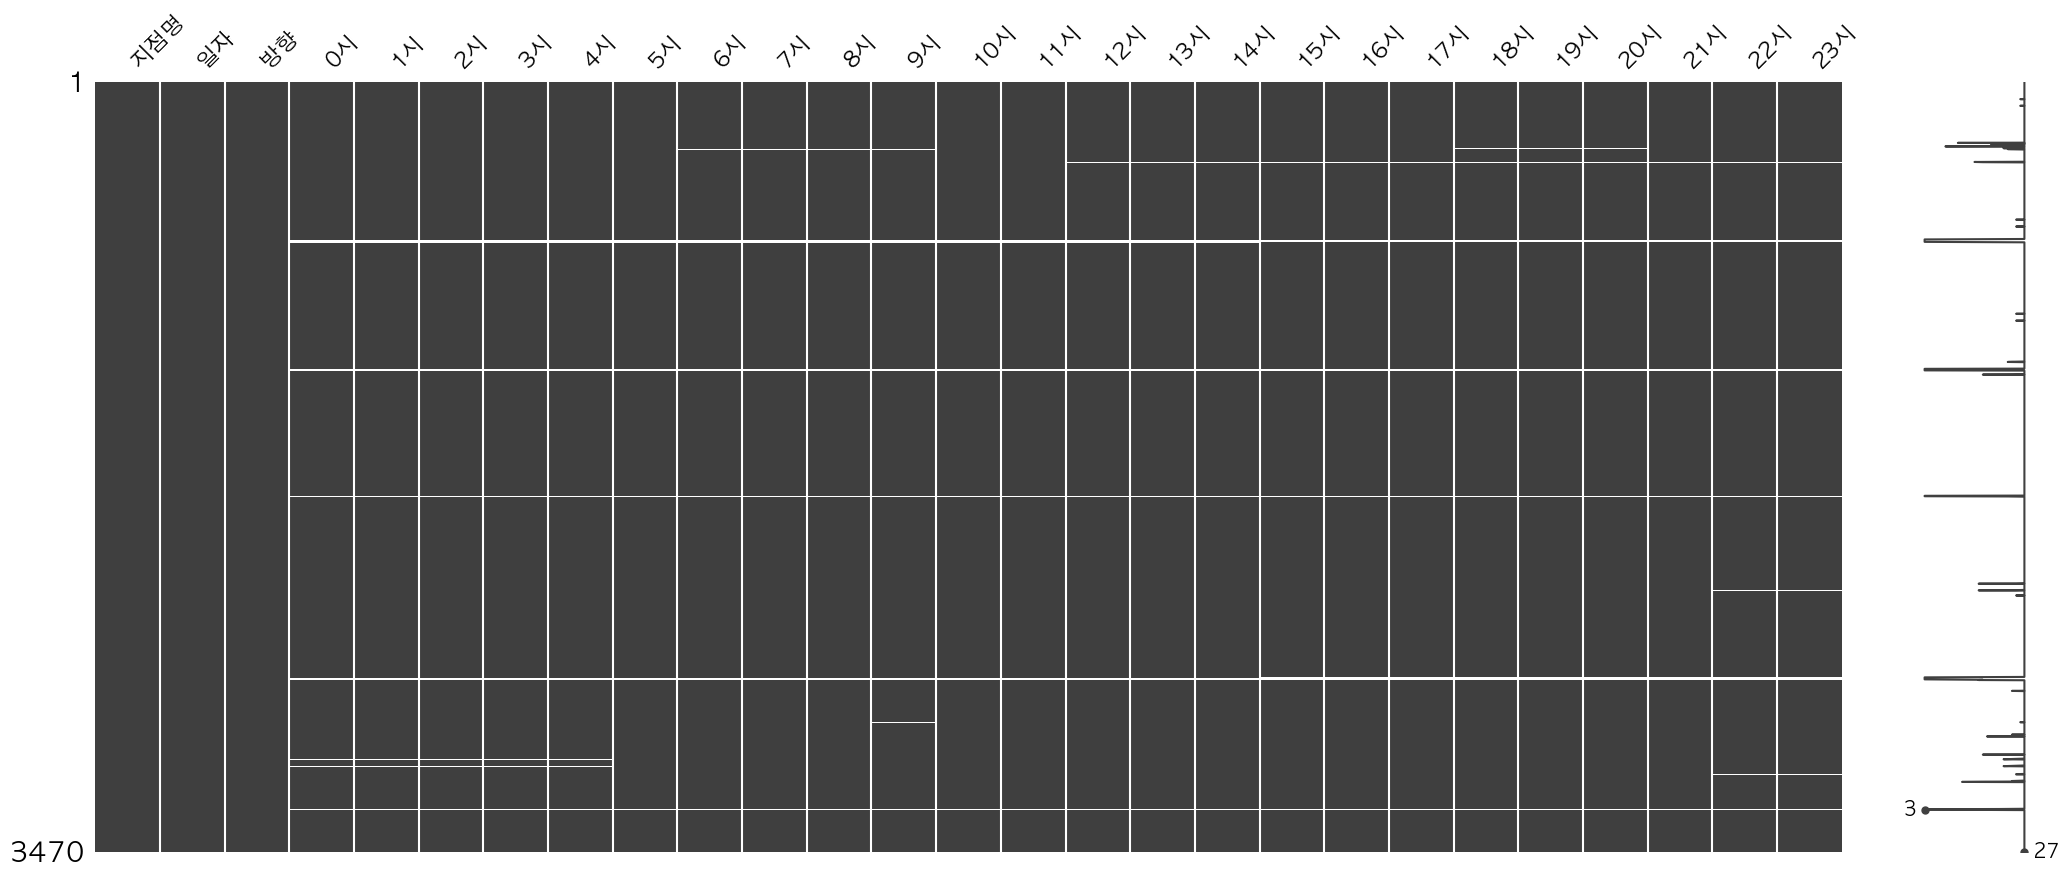

In [474]:
msno.matrix(df_traffic)

> 특정일에서 시간별 교통량 결측치 확인됨

In [475]:
df_traffic['일자']
#  타입 변경
df_traffic['일자']=df_traffic['일자'].astype(str)

In [476]:
df_traffic['일자']

0       20220301
1       20220302
2       20220303
3       20220304
4       20220305
          ...   
3465    20220626
3466    20220627
3467    20220628
3468    20220629
3469    20220630
Name: 일자, Length: 3470, dtype: object

In [479]:
# 년도, 월 구분을 위한 타입 변경
# df_traffic['일자']
df_traffic['일자']=pd.to_datetime(df_traffic['일자'], format='%Y%m%d')


In [480]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3470 entries, 0 to 3469
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지점명     3470 non-null   object        
 1   일자      3470 non-null   datetime64[ns]
 2   방향      3470 non-null   object        
 3   0시      3419 non-null   float64       
 4   1시      3419 non-null   float64       
 5   2시      3420 non-null   float64       
 6   3시      3421 non-null   float64       
 7   4시      3421 non-null   float64       
 8   5시      3423 non-null   float64       
 9   6시      3420 non-null   float64       
 10  7시      3419 non-null   float64       
 11  8시      3418 non-null   float64       
 12  9시      3415 non-null   float64       
 13  10시     3418 non-null   float64       
 14  11시     3422 non-null   float64       
 15  12시     3420 non-null   float64       
 16  13시     3421 non-null   float64       
 17  14시     3417 non-null   float64       
 18  15시     

In [ ]:
# 월, 년도 컬럼 추가

df_traffic['년도'] = df_traffic['일자'].dt.year
df_traffic['월'] = df_traffic['일자'].dt.month

In [ ]:
# 평일, 휴일 , 주말 나누기
# 대한민국 공휴일 가져오기
kr_holidays = holidays.KR(years=range(2020,2025))

# 날짜가 공휴일인지를 체크하는 함수 추가
df_traffic['휴일여부'] = df_traffic['일자'].apply(lambda x: '휴일' if x in kr_holidays else ('주말' if x.weekday() >= 5 else '평일'))
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3010 entries, 214 to 3453
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지점명     3010 non-null   object        
 1   날짜      3010 non-null   datetime64[ns]
 2   휴일여부    3010 non-null   object        
 3   아침 비율   3010 non-null   float64       
 4   낮 비율    3010 non-null   float64       
 5   저녁 비율   3010 non-null   float64       
 6   월       3010 non-null   int32         
 7   년도      3010 non-null   int32         
 8   일       3010 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(3), object(2)
memory usage: 199.9+ KB


In [493]:
# 작업을 위해 분리
traffic_y = df_traffic[df_traffic['지점명'] == '영동대교']
traffic_c = df_traffic[df_traffic['지점명'] == '청담대교']

In [ ]:
traffic_c.head()


Index(['0시', '1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시', '10시',
       '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시',
       '21시', '22시', '23시'],
      dtype='object')

In [504]:
t_col=traffic_c.columns[3:27]

In [514]:
traffic_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1735 entries, 31 to 3469
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지점명     1735 non-null   object        
 1   일자      1735 non-null   datetime64[ns]
 2   방향      1735 non-null   object        
 3   0시      1707 non-null   float64       
 4   1시      1707 non-null   float64       
 5   2시      1707 non-null   float64       
 6   3시      1708 non-null   float64       
 7   4시      1708 non-null   float64       
 8   5시      1709 non-null   float64       
 9   6시      1706 non-null   float64       
 10  7시      1705 non-null   float64       
 11  8시      1704 non-null   float64       
 12  9시      1702 non-null   float64       
 13  10시     1705 non-null   float64       
 14  11시     1707 non-null   float64       
 15  12시     1705 non-null   float64       
 16  13시     1707 non-null   float64       
 17  14시     1706 non-null   float64       
 18  15시     1710

In [537]:
# nan 값 대치를 위해 평균대치법 사용(월, 휴일여부, 시간에 따른 평균값으로 대치)
t_col

Index(['0시', '1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시', '10시',
       '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시', '19시', '20시',
       '21시', '22시', '23시'],
      dtype='object')

In [ ]:

for col in t_col:
    # 각 시간대별로 평균 계산
    mean = traffic_c.groupby(['휴일여부', '월'])[col].mean()
    value_dict = mean.to_dict()

    # NaN 값을 대체하는 함수 정의
    def replace_nan(row):
        if pd.isna(row[col]):
            key = (row['휴일여부'], row['월'])
            return value_dict.get(key, row[col])
        return row[col]

    # 해당 열의 NaN 값을 대체
    traffic_c[col] = traffic_c.apply(replace_nan, axis=1)

# 결과 확인
# print(traffic_c[['휴일여부', '월'] + t_col])

In [551]:
traffic_c.describe()

,일자,0시,1시,2시,3시,4시,5시,6시,7시,8시,...,16시,17시,18시,19시,20시,21시,22시,23시,년도,월
count,1735,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,...,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000,1735.000000
mean,2022-05-17 00:00:00,1033.048769,746.509184,548.049430,500.164281,627.418436,1290.168695,2474.081124,2865.123514,2974.591818,...,3549.699451,3418.753829,3129.368028,3125.318512,3185.578847,3043.623031,2566.344793,1624.752768,2021.893948,6.283573
min,2020-01-01 00:00:00,403.000000,291.000000,171.000000,119.000000,151.000000,218.000000,413.000000,619.000000,1051.000000,...,1652.000000,2034.000000,1637.000000,1334.000000,1321.000000,1258.000000,811.000000,631.000000,2020.000000,1.000000
25%,2021-03-09 12:00:00,895.000000,644.500000,473.500000,437.000000,572.500000,1110.000000,2048.000000,2392.000000,2858.000000,...,3404.500000,3245.000000,2962.000000,2951.000000,2941.000000,2817.000000,2277.500000,1400.000000,2021.000000,3.000000
50%,2022-05-17 00:00:00,1020.000000,738.000000,545.000000,507.000000,656.000000,1389.000000,2838.000000,3248.000000,3141.000000,...,3584.000000,3418.000000,3125.000000,3172.000000,3198.000000,3067.000000,2557.000000,1600.000000,2022.000000,6.000000
75%,2023-07-24 12:00:00,1155.000000,828.000000,616.000000,567.000000,722.500000,1562.500000,3035.000000,3406.000000,3270.500000,...,3716.000000,3596.000000,3302.500000,3358.000000,3471.500000,3293.000000,2867.000000,1799.000000,2023.000000,9.000000
max,2024-09-30 00:00:00,1639.000000,1554.000000,910.000000,817.000000,1070.000000,2262.000000,3738.000000,4046.000000,4093.000000,...,4652.000000,4454.000000,4180.000000,4147.000000,4224.000000,4097.000000,4375.000000,4033.000000,2024.000000,12.000000
std,NaN,201.493553,147.554043,112.082965,106.271121,140.393620,386.187007,783.333567,789.497273,501.844447,...,272.226925,294.034139,275.902196,355.872622,400.129904,366.692125,460.323435,330.403026,1.373351,3.373217


In [557]:
y_col=traffic_y.columns[3:27]

In [558]:

for col in y_col:
    # 각 시간대별로 평균 계산
    mean = traffic_y.groupby(['휴일여부', '월'])[col].mean()
    value_dict = mean.to_dict()

    # NaN 값을 대체하는 함수 정의
    def replace_nan(row):
        if pd.isna(row[col]):
            key = (row['휴일여부'], row['월'])
            return value_dict.get(key, row[col])
        return row[col]

    # 해당 열의 NaN 값을 대체
    traffic_y[col] = traffic_y.apply(replace_nan, axis=1)

# 결과 확인
# print(traffic_c[['휴일여부', '월'] + t_col])

In [559]:
traffic_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1735 entries, 0 to 3439
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지점명     1735 non-null   object        
 1   일자      1735 non-null   datetime64[ns]
 2   방향      1735 non-null   object        
 3   0시      1735 non-null   float64       
 4   1시      1735 non-null   float64       
 5   2시      1735 non-null   float64       
 6   3시      1735 non-null   float64       
 7   4시      1735 non-null   float64       
 8   5시      1735 non-null   float64       
 9   6시      1735 non-null   float64       
 10  7시      1735 non-null   float64       
 11  8시      1735 non-null   float64       
 12  9시      1735 non-null   float64       
 13  10시     1735 non-null   float64       
 14  11시     1735 non-null   float64       
 15  12시     1735 non-null   float64       
 16  13시     1735 non-null   float64       
 17  14시     1735 non-null   float64       
 18  15시     1735 

In [564]:

print(len(pd.concat([traffic_y, traffic_c])) == len(df_traffic))
df_traffic = pd.concat([traffic_c, traffic_y])

True


In [584]:
traffic_c.reset_index(drop=True,inplace=True)

In [565]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3470 entries, 31 to 3439
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지점명     3470 non-null   object        
 1   일자      3470 non-null   datetime64[ns]
 2   방향      3470 non-null   object        
 3   0시      3470 non-null   float64       
 4   1시      3470 non-null   float64       
 5   2시      3470 non-null   float64       
 6   3시      3470 non-null   float64       
 7   4시      3470 non-null   float64       
 8   5시      3470 non-null   float64       
 9   6시      3470 non-null   float64       
 10  7시      3470 non-null   float64       
 11  8시      3470 non-null   float64       
 12  9시      3470 non-null   float64       
 13  10시     3470 non-null   float64       
 14  11시     3470 non-null   float64       
 15  12시     3470 non-null   float64       
 16  13시     3470 non-null   float64       
 17  14시     3470 non-null   float64       
 18  15시     3470

In [576]:
df_traffic.sort_values(['지점명','일자'], ascending=False, inplace= True)

In [577]:
df_traffic.reset_index(drop=True, inplace= True)

In [578]:
df_traffic.to_csv('../../Data/뚝섬교통데이터.csv', index=False)

> 월, 휴일여부 로 그룹화 하여 각 시간별 평균을 구함 ---> nan값 대치


In [581]:
# df_traffic
df_weather

,지구별,주차장명,주차대수,이용시간,날짜,년도,월,일,휴일여부,1대당 평균 주차시간,평균기온,최저기온,최저기온 시각(hhmi),최고기온,최고기온 시각(hhmi),평균 상대습도(%),평균온도 구분,최고기온 구분,최저기온 구분
0,PLT-005,뚝섬2주차장,518,54850.0,2024-02-29,2024,2,29,0,105.888031,4.8,0.3,2400.0,9.6,1539,63.6,0,9,-4
1,PLT-005,뚝섬1주차장,175,10098.0,2024-02-29,2024,2,29,0,57.702857,4.8,0.3,2400.0,9.6,1539,63.6,0,9,-4
2,PLT-005,뚝섬3주차장,260,20227.0,2024-02-29,2024,2,29,0,77.796154,4.8,0.3,2400.0,9.6,1539,63.6,0,9,-4
3,PLT-005,뚝섬4주차장,526,54791.0,2024-02-29,2024,2,29,0,104.165399,4.8,0.3,2400.0,9.6,1539,63.6,0,9,-4
4,PLT-005,뚝섬3주차장,195,17464.0,2024-02-28,2024,2,28,0,89.558974,6.4,3.2,712.0,10.1,1509,59.5,5,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,PLT-005,뚝섬2주차장,127,30987.0,2020-01-21,2020,1,21,0,243.992126,-0.4,-5.6,800.0,5.5,1541,36.9,-5,4,-9
5936,PLT-005,뚝섬3주차장,58,1468.0,2020-01-20,2020,1,20,0,25.310345,0.7,-3.3,2324.0,5.5,1313,46.8,0,4,-4
5937,PLT-005,뚝섬3주차장,242,14229.0,2020-01-19,2020,1,19,1,58.797521,1.9,-0.4,3.0,5.3,1510,62.8,0,4,-4
5938,PLT-005,뚝섬3주차장,253,18191.0,2020-01-18,2020,1,18,1,71.901186,0.3,-4.1,802.0,5.9,1503,48.1,0,4,-9


In [586]:
df_traffic

,지점명,일자,방향,0시,1시,2시,3시,4시,5시,6시,...,17시,18시,19시,20시,21시,22시,23시,년도,월,휴일여부
0,청담대교,2024-09-30,유입,875.0,630.0,493.0,480.0,762.0,2012.0,3183.0,...,3381.0,2888.0,3249.0,3386.0,3117.0,2490.0,1821.0,2024,9,평일
1,청담대교,2024-09-29,유입,1037.0,731.0,517.0,449.0,489.0,798.0,1252.0,...,3299.0,3085.0,3112.0,3164.0,3019.0,2152.0,1352.0,2024,9,주말
2,청담대교,2024-09-28,유입,1381.0,1059.0,763.0,687.0,852.0,1654.0,2386.0,...,2996.0,2573.0,3002.0,3049.0,3022.0,2523.0,1600.0,2024,9,주말
3,청담대교,2024-09-27,유입,1265.0,895.0,666.0,611.0,883.0,1912.0,3096.0,...,2927.0,2499.0,2981.0,3537.0,3495.0,3147.0,2060.0,2024,9,평일
4,청담대교,2024-09-26,유입,1155.0,819.0,613.0,533.0,823.0,1885.0,3106.0,...,3309.0,2780.0,3576.0,3406.0,3243.0,3417.0,2175.0,2024,9,평일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,영동대교,2020-01-05,유입,1277.0,946.0,826.0,633.0,532.0,545.0,687.0,...,2958.0,2895.0,2292.0,2178.0,2016.0,1876.0,1108.0,2020,1,주말
3466,영동대교,2020-01-04,유입,1727.0,1305.0,1059.0,886.0,769.0,789.0,1027.0,...,3793.0,3803.0,3063.0,2678.0,2521.0,2529.0,1605.0,2020,1,주말
3467,영동대교,2020-01-03,유입,1511.0,1158.0,880.0,714.0,607.0,785.0,1215.0,...,3964.0,3790.0,4065.0,4235.0,3266.0,3315.0,2182.0,2020,1,평일
3468,영동대교,2020-01-02,유입,817.0,623.0,426.0,330.0,386.0,593.0,1160.0,...,4110.0,4333.0,4138.0,3379.0,3036.0,3064.0,1876.0,2020,1,평일


In [587]:
df_traffic

,지점명,일자,방향,0시,1시,2시,3시,4시,5시,6시,...,17시,18시,19시,20시,21시,22시,23시,년도,월,휴일여부
0,청담대교,2024-09-30,유입,875.0,630.0,493.0,480.0,762.0,2012.0,3183.0,...,3381.0,2888.0,3249.0,3386.0,3117.0,2490.0,1821.0,2024,9,평일
1,청담대교,2024-09-29,유입,1037.0,731.0,517.0,449.0,489.0,798.0,1252.0,...,3299.0,3085.0,3112.0,3164.0,3019.0,2152.0,1352.0,2024,9,주말
2,청담대교,2024-09-28,유입,1381.0,1059.0,763.0,687.0,852.0,1654.0,2386.0,...,2996.0,2573.0,3002.0,3049.0,3022.0,2523.0,1600.0,2024,9,주말
3,청담대교,2024-09-27,유입,1265.0,895.0,666.0,611.0,883.0,1912.0,3096.0,...,2927.0,2499.0,2981.0,3537.0,3495.0,3147.0,2060.0,2024,9,평일
4,청담대교,2024-09-26,유입,1155.0,819.0,613.0,533.0,823.0,1885.0,3106.0,...,3309.0,2780.0,3576.0,3406.0,3243.0,3417.0,2175.0,2024,9,평일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,영동대교,2020-01-05,유입,1277.0,946.0,826.0,633.0,532.0,545.0,687.0,...,2958.0,2895.0,2292.0,2178.0,2016.0,1876.0,1108.0,2020,1,주말
3466,영동대교,2020-01-04,유입,1727.0,1305.0,1059.0,886.0,769.0,789.0,1027.0,...,3793.0,3803.0,3063.0,2678.0,2521.0,2529.0,1605.0,2020,1,주말
3467,영동대교,2020-01-03,유입,1511.0,1158.0,880.0,714.0,607.0,785.0,1215.0,...,3964.0,3790.0,4065.0,4235.0,3266.0,3315.0,2182.0,2020,1,평일
3468,영동대교,2020-01-02,유입,817.0,623.0,426.0,330.0,386.0,593.0,1160.0,...,4110.0,4333.0,4138.0,3379.0,3036.0,3064.0,1876.0,2020,1,평일


In [595]:
df_traffic['아침']=df_traffic.loc[:,['6시','7시','8시','9시','10시']].sum(axis='columns')
df_traffic['낮']=df_traffic.loc[:,['11시','12시','13시','14시','15시','16시','17시']].sum(axis='columns')
df_traffic['저녁']=df_traffic.loc[:,['0시','18시','19시','20시','21시','22시','23시']].sum(axis='columns')

In [599]:
# df_traffic[['지점명','일자','아침','낮','저녁']]
df_traffic['아침 비율']=df_traffic['아침'] / df_traffic[['아침','낮','저녁']].sum(axis='columns')
df_traffic['낮 비율']=df_traffic['낮'] / df_traffic[['아침','낮','저녁']].sum(axis='columns')
df_traffic['저녁 비율']=df_traffic['저녁'] / df_traffic[['아침','낮','저녁']].sum(axis='columns')

> 시간 합치기 : 아침 6~10 / 낮 11~17 / 저녁 18~0                
> 아침, 낮, 저녁별로 교통량 비율 컬럼 추가

In [626]:
df_traffic

,지점명,일자,방향,0시,1시,2시,3시,4시,5시,6시,...,년도,월,휴일여부,아침,낮,저녁,아침 비율,낮 비율,저녁 비율,일
0,청담대교,2024-09-30,유입,875.0,630.0,493.0,480.0,762.0,2012.0,3183.0,...,2024,9,NaN,16117.0,23644.0,17826.0,0.279872,0.410579,0.309549,30
1,청담대교,2024-09-29,유입,1037.0,731.0,517.0,449.0,489.0,798.0,1252.0,...,2024,9,NaN,12715.0,22668.0,16921.0,0.243098,0.433389,0.323513,29
2,청담대교,2024-09-28,유입,1381.0,1059.0,763.0,687.0,852.0,1654.0,2386.0,...,2024,9,NaN,15777.0,23672.0,17150.0,0.278751,0.418241,0.303009,28
3,청담대교,2024-09-27,유입,1265.0,895.0,666.0,611.0,883.0,1912.0,3096.0,...,2024,9,NaN,16329.0,23325.0,18984.0,0.278471,0.397780,0.323749,27
4,청담대교,2024-09-26,유입,1155.0,819.0,613.0,533.0,823.0,1885.0,3106.0,...,2024,9,NaN,16385.0,22180.0,19752.0,0.280964,0.380335,0.338701,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,영동대교,2020-01-05,유입,1277.0,946.0,826.0,633.0,532.0,545.0,687.0,...,2020,1,NaN,6921.0,19578.0,13642.0,0.172417,0.487731,0.339852,5
3466,영동대교,2020-01-04,유입,1727.0,1305.0,1059.0,886.0,769.0,789.0,1027.0,...,2020,1,NaN,10011.0,24595.0,17926.0,0.190570,0.468191,0.341240,4
3467,영동대교,2020-01-03,유입,1511.0,1158.0,880.0,714.0,607.0,785.0,1215.0,...,2020,1,NaN,11577.0,24304.0,22364.0,0.198764,0.417272,0.383964,3
3468,영동대교,2020-01-02,유입,817.0,623.0,426.0,330.0,386.0,593.0,1160.0,...,2020,1,NaN,11201.0,23585.0,20643.0,0.202078,0.425499,0.372422,2


In [625]:
df_weather['휴일여부'].unique()

array([0, 1])

In [615]:
df_weather.drop(['최저기온 시각(hhmi)','최고기온 시각(hhmi)','평균 상대습도(%)'],axis=1, inplace=True)

### 일별 주차장 데이터와 합치기 위해 날짜 맞춰주기

In [668]:
df_weather['날짜'].sort_values(ascending=False)

0      2024-02-29
3      2024-02-29
1      2024-02-29
2      2024-02-29
6      2024-02-28
          ...    
5935   2020-01-21
5936   2020-01-20
5937   2020-01-19
5938   2020-01-18
5939   2020-01-17
Name: 날짜, Length: 5940, dtype: datetime64[ns]

In [675]:
df_traffic.rename(columns={'일자':'날짜'},inplace=True)

In [676]:
df_traffic['날짜'].sort_values(ascending=False)

0      2024-09-30
1735   2024-09-30
1736   2024-09-29
1      2024-09-29
1737   2024-09-28
          ...    
3467   2020-01-03
1733   2020-01-02
3468   2020-01-02
1734   2020-01-01
3469   2020-01-01
Name: 날짜, Length: 3470, dtype: datetime64[ns]

In [677]:
start_date = '2020-01-17'
end_date = '2024-02-29'

# 날짜 범위로 필터링
df_traffic = df_traffic[(df_traffic['날짜'] >= start_date) & (df_traffic['날짜'] <= end_date)]

df_traffic['날짜'].sort_values(ascending=False)

214    2024-02-29
1949   2024-02-29
1950   2024-02-28
215    2024-02-28
1951   2024-02-27
          ...    
3451   2020-01-19
3452   2020-01-18
1717   2020-01-18
1718   2020-01-17
3453   2020-01-17
Name: 날짜, Length: 3010, dtype: datetime64[ns]

> 교통량 데이터를 기준으로 날짜 맞춰줌

In [684]:
# 병합을 위해 traffic의 평일, 주말, 휴일을 숫자로 변경
df_traffic['휴일여부']=df_traffic['휴일여부'].map({'평일':0,'주말':1,'휴일':1})

In [685]:
df_traffic['휴일여부'].unique()

array([0, 1])

In [ ]:
df_traffic['일'] = df_traffic['날짜'].dt.day

In [688]:
df_traffic=df_traffic[['지점명','날짜','휴일여부','아침 비율','낮 비율', '저녁 비율','월','년도','일']]

In [689]:
traffic_c=df_traffic[df_traffic['지점명']=='청담대교']
traffic_y=df_traffic[df_traffic['지점명']=='영동대교']

In [690]:
traffic_y.head()

,지점명,날짜,휴일여부,아침 비율,낮 비율,저녁 비율,월,년도,일
1949,영동대교,2024-02-29,0,0.188226,0.429115,0.382659,2,2024,29
1950,영동대교,2024-02-28,0,0.200213,0.431652,0.368134,2,2024,28
1951,영동대교,2024-02-27,0,0.198310,0.434136,0.367554,2,2024,27
1952,영동대교,2024-02-26,0,0.200553,0.447434,0.352013,2,2024,26
1953,영동대교,2024-02-25,1,0.181405,0.487784,0.330811,2,2024,25


In [691]:
traffic_c.head()

,지점명,날짜,휴일여부,아침 비율,낮 비율,저녁 비율,월,년도,일
214,청담대교,2024-02-29,0,0.264305,0.395477,0.340218,2,2024,29
215,청담대교,2024-02-28,0,0.275049,0.417107,0.307844,2,2024,28
216,청담대교,2024-02-27,0,0.274294,0.421402,0.304304,2,2024,27
217,청담대교,2024-02-26,0,0.292647,0.423629,0.283725,2,2024,26
218,청담대교,2024-02-25,1,0.215397,0.477302,0.307301,2,2024,25


In [ ]:
len(traffic_c.index) == len(traffic_y.index)

True

In [665]:
traffic_c.rename(columns={'일자':'날짜'},inplace=True)

In [694]:
print(df_weather.columns)
print(traffic_c.columns)
print(traffic_y.columns)

Index(['지구별', '주차장명', '주차대수', '이용시간', '날짜', '년도', '월', '일', '휴일여부',
       '1대당 평균 주차시간', '평균기온', '최저기온', '최고기온', '평균온도 구분', '최고기온 구분', '최저기온 구분'],
      dtype='object')
Index(['지점명', '날짜', '휴일여부', '아침 비율', '낮 비율', '저녁 비율', '월', '년도', '일'], dtype='object')
Index(['지점명', '날짜', '휴일여부', '아침 비율', '낮 비율', '저녁 비율', '월', '년도', '일'], dtype='object')


In [700]:
traffic_c.drop(['년도','월','일','휴일여부'],axis=1, inplace=True)
traffic_y.drop(['년도','월','일','휴일여부'],axis=1, inplace=True)

In [702]:
traffic_merge=pd.merge(traffic_c,traffic_y,on='날짜',suffixes=('_청담','_영동'))

In [707]:
final_merge=pd.merge(df_weather,traffic_merge,on='날짜')

In [708]:
final_merge

,지구별,주차장명,주차대수,이용시간,날짜,년도,월,일,휴일여부,1대당 평균 주차시간,...,최고기온 구분,최저기온 구분,지점명_청담,아침 비율_청담,낮 비율_청담,저녁 비율_청담,지점명_영동,아침 비율_영동,낮 비율_영동,저녁 비율_영동
0,PLT-005,뚝섬2주차장,518,54850.0,2024-02-29,2024,2,29,0,105.888031,...,9,-4,청담대교,0.264305,0.395477,0.340218,영동대교,0.188226,0.429115,0.382659
1,PLT-005,뚝섬1주차장,175,10098.0,2024-02-29,2024,2,29,0,57.702857,...,9,-4,청담대교,0.264305,0.395477,0.340218,영동대교,0.188226,0.429115,0.382659
2,PLT-005,뚝섬3주차장,260,20227.0,2024-02-29,2024,2,29,0,77.796154,...,9,-4,청담대교,0.264305,0.395477,0.340218,영동대교,0.188226,0.429115,0.382659
3,PLT-005,뚝섬4주차장,526,54791.0,2024-02-29,2024,2,29,0,104.165399,...,9,-4,청담대교,0.264305,0.395477,0.340218,영동대교,0.188226,0.429115,0.382659
4,PLT-005,뚝섬3주차장,195,17464.0,2024-02-28,2024,2,28,0,89.558974,...,9,1,청담대교,0.275049,0.417107,0.307844,영동대교,0.200213,0.431652,0.368134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,PLT-005,뚝섬2주차장,127,30987.0,2020-01-21,2020,1,21,0,243.992126,...,4,-9,청담대교,0.267244,0.413718,0.319039,영동대교,0.185738,0.425626,0.388636
5936,PLT-005,뚝섬3주차장,58,1468.0,2020-01-20,2020,1,20,0,25.310345,...,4,-4,청담대교,0.271472,0.413979,0.314549,영동대교,0.190675,0.437027,0.372299
5937,PLT-005,뚝섬3주차장,242,14229.0,2020-01-19,2020,1,19,1,58.797521,...,4,-4,청담대교,0.209281,0.472601,0.318117,영동대교,0.173643,0.486582,0.339775
5938,PLT-005,뚝섬3주차장,253,18191.0,2020-01-18,2020,1,18,1,71.901186,...,4,-9,청담대교,0.250248,0.433022,0.316730,영동대교,0.187630,0.461903,0.350467


In [ ]:
# final_merge.to_csv('../../Data/최종.csv',index=False)

---------------------
# 최종 버전

In [61]:
final_merge = pd.read_csv('../../Data/최종.csv')

In [62]:
final_merge.head()

,지구별,주차장명,주차대수,이용시간,날짜,년도,월,일,휴일여부,1대당 평균 주차시간,...,최고기온 구분,최저기온 구분,지점명_청담,아침 비율_청담,낮 비율_청담,저녁 비율_청담,지점명_영동,아침 비율_영동,낮 비율_영동,저녁 비율_영동
0,PLT-005,뚝섬2주차장,518,54850.0,2024-02-29,2024,2,29,0,105.888031,...,9,-4,청담대교,0.264305,0.395477,0.340218,영동대교,0.188226,0.429115,0.382659
1,PLT-005,뚝섬1주차장,175,10098.0,2024-02-29,2024,2,29,0,57.702857,...,9,-4,청담대교,0.264305,0.395477,0.340218,영동대교,0.188226,0.429115,0.382659
2,PLT-005,뚝섬3주차장,260,20227.0,2024-02-29,2024,2,29,0,77.796154,...,9,-4,청담대교,0.264305,0.395477,0.340218,영동대교,0.188226,0.429115,0.382659
3,PLT-005,뚝섬4주차장,526,54791.0,2024-02-29,2024,2,29,0,104.165399,...,9,-4,청담대교,0.264305,0.395477,0.340218,영동대교,0.188226,0.429115,0.382659
4,PLT-005,뚝섬3주차장,195,17464.0,2024-02-28,2024,2,28,0,89.558974,...,9,1,청담대교,0.275049,0.417107,0.307844,영동대교,0.200213,0.431652,0.368134


In [63]:
# final_merge.columns
df_final=final_merge.drop(['일','지점명_청담','지점명_영동'],axis=1)

In [64]:
df_final['날짜']=pd.to_datetime(df_final['날짜'])

In [65]:
# 0:월요일 ~ 6:일요일
df_final['요일']=df_final['날짜'].dt.weekday

<Axes: >

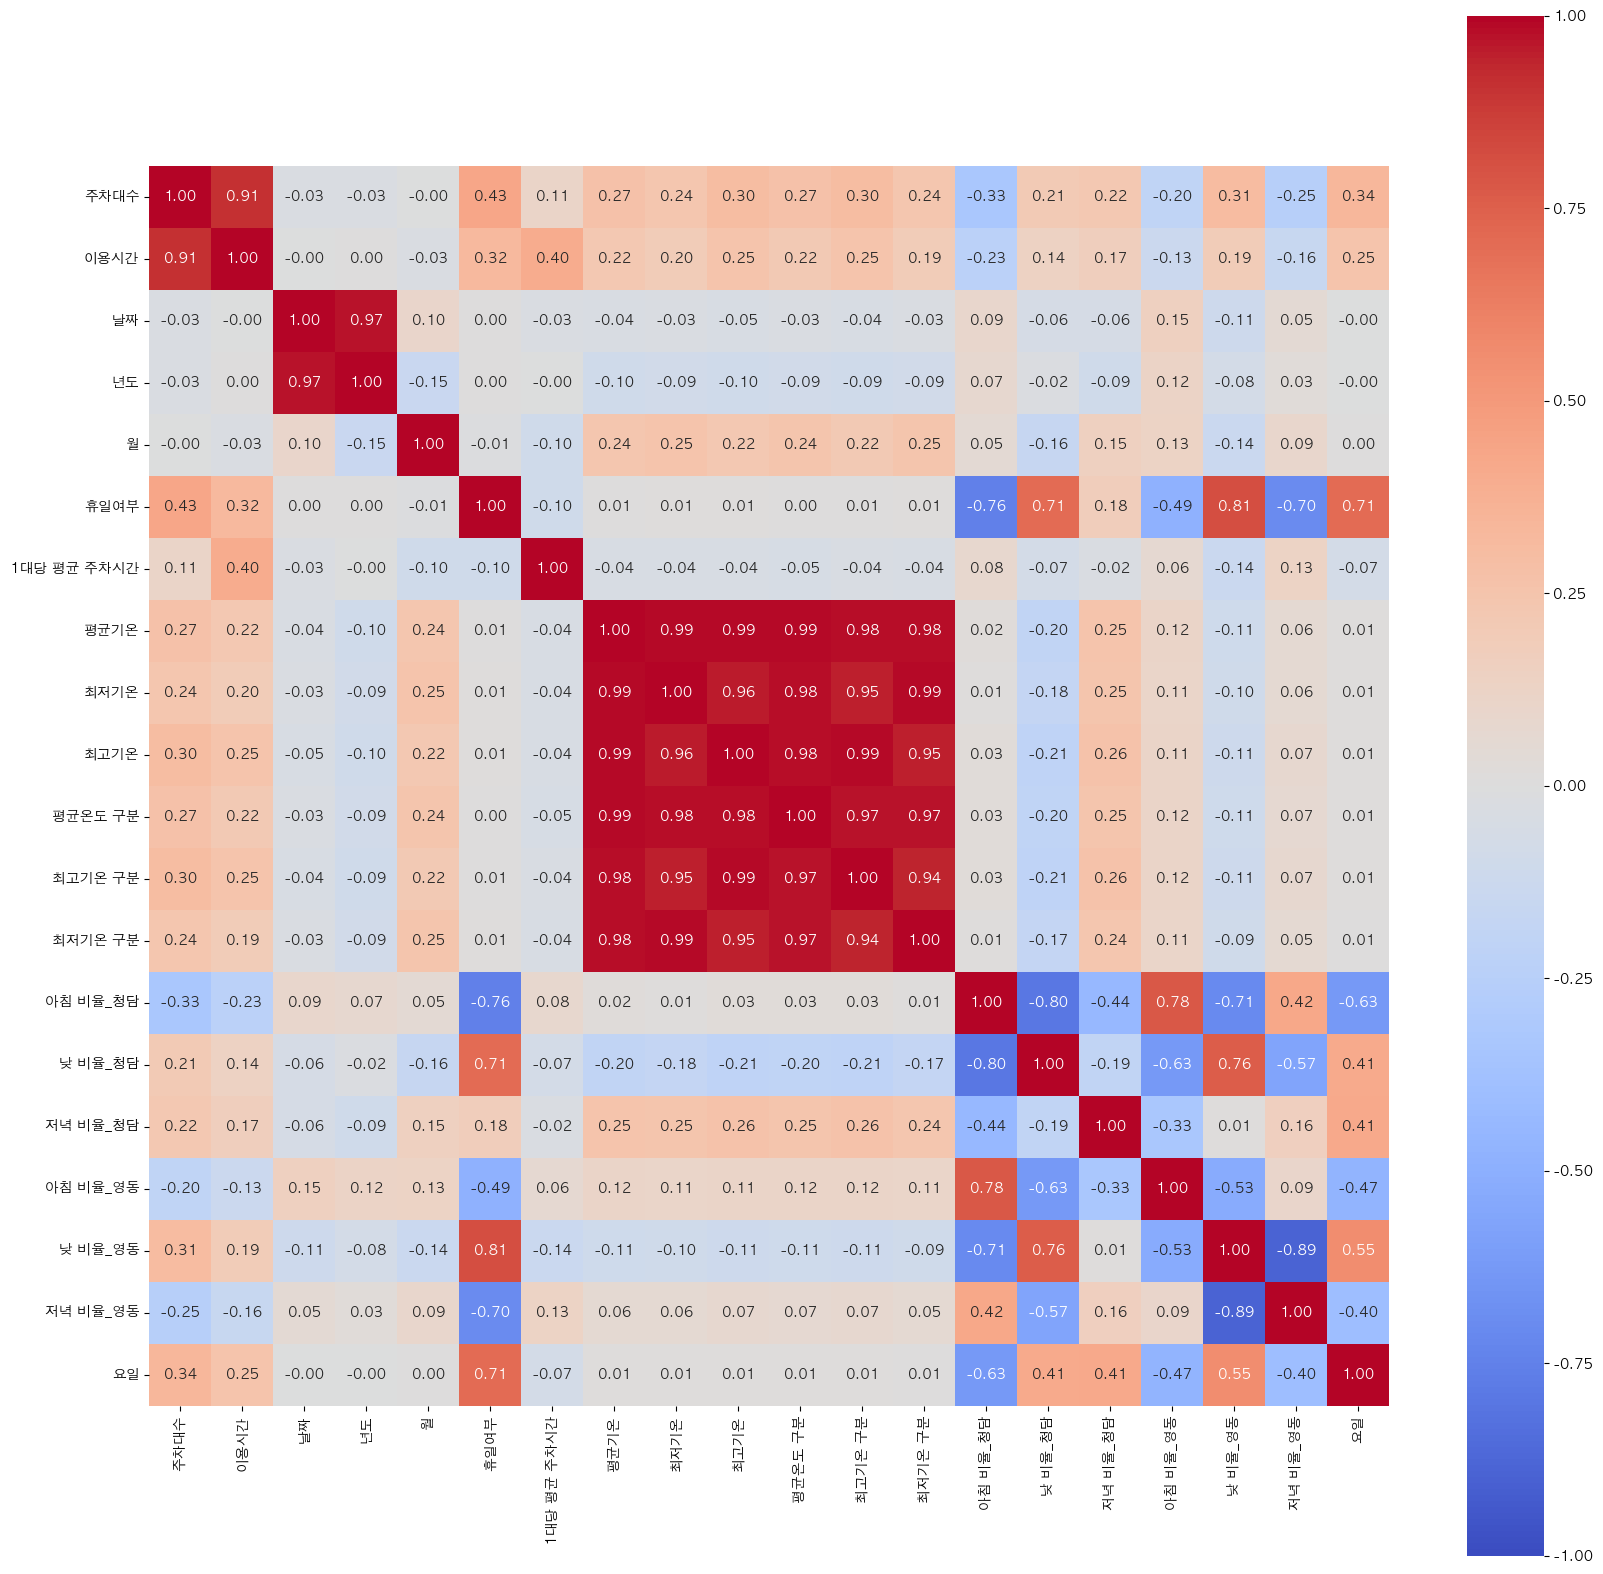

In [66]:
plt.figure(figsize=(20,20))
sns.heatmap(df_final.iloc[:,2:].corr(),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            )

In [67]:
df_final

,지구별,주차장명,주차대수,이용시간,날짜,년도,월,휴일여부,1대당 평균 주차시간,평균기온,...,평균온도 구분,최고기온 구분,최저기온 구분,아침 비율_청담,낮 비율_청담,저녁 비율_청담,아침 비율_영동,낮 비율_영동,저녁 비율_영동,요일
0,PLT-005,뚝섬2주차장,518,54850.0,2024-02-29,2024,2,0,105.888031,4.8,...,0,9,-4,0.264305,0.395477,0.340218,0.188226,0.429115,0.382659,3
1,PLT-005,뚝섬1주차장,175,10098.0,2024-02-29,2024,2,0,57.702857,4.8,...,0,9,-4,0.264305,0.395477,0.340218,0.188226,0.429115,0.382659,3
2,PLT-005,뚝섬3주차장,260,20227.0,2024-02-29,2024,2,0,77.796154,4.8,...,0,9,-4,0.264305,0.395477,0.340218,0.188226,0.429115,0.382659,3
3,PLT-005,뚝섬4주차장,526,54791.0,2024-02-29,2024,2,0,104.165399,4.8,...,0,9,-4,0.264305,0.395477,0.340218,0.188226,0.429115,0.382659,3
4,PLT-005,뚝섬3주차장,195,17464.0,2024-02-28,2024,2,0,89.558974,6.4,...,5,9,1,0.275049,0.417107,0.307844,0.200213,0.431652,0.368134,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,PLT-005,뚝섬2주차장,127,30987.0,2020-01-21,2020,1,0,243.992126,-0.4,...,-5,4,-9,0.267244,0.413718,0.319039,0.185738,0.425626,0.388636,1
5936,PLT-005,뚝섬3주차장,58,1468.0,2020-01-20,2020,1,0,25.310345,0.7,...,0,4,-4,0.271472,0.413979,0.314549,0.190675,0.437027,0.372299,0
5937,PLT-005,뚝섬3주차장,242,14229.0,2020-01-19,2020,1,1,58.797521,1.9,...,0,4,-4,0.209281,0.472601,0.318117,0.173643,0.486582,0.339775,6
5938,PLT-005,뚝섬3주차장,253,18191.0,2020-01-18,2020,1,1,71.901186,0.3,...,0,4,-9,0.250248,0.433022,0.316730,0.187630,0.461903,0.350467,5


In [68]:
# 영동대교 기반 주차대수 분리
df_final['영동_아침주차'] = df_final['주차대수'] * df_final['아침 비율_영동']
df_final['영동_낮주차'] = df_final['주차대수'] * df_final['낮 비율_영동']
df_final['영동_저녁주차'] = df_final['주차대수'] * df_final['저녁 비율_영동']

In [69]:
# 청담대교 기반 주차대수 분리
df_final['청담_아침주차'] = df_final['주차대수'] * df_final['아침 비율_청담']
df_final['청담_낮주차'] = df_final['주차대수'] * df_final['낮 비율_청담']
df_final['청담_저녁주차'] = df_final['주차대수'] * df_final['저녁 비율_청담']

In [70]:
# 영동대교 기반 이용시간 분리
df_final['영동_아침이용'] = df_final['이용시간'] * df_final['아침 비율_영동']
df_final['영동_낮이용'] = df_final['이용시간'] * df_final['낮 비율_영동']
df_final['영동_저녁이용'] = df_final['이용시간'] * df_final['저녁 비율_영동']

In [71]:
# 청담대교 기반 이용시간 분리
df_final['청담_아침이용'] = df_final['이용시간'] * df_final['아침 비율_청담']
df_final['청담_낮이용'] = df_final['이용시간'] * df_final['낮 비율_청담']
df_final['청담_저녁이용'] = df_final['이용시간'] * df_final['저녁 비율_청담']

In [72]:
df_final['총 주차 대수'] = df_final['주차장명'].map({'뚝섬2주차장':356, '뚝섬1주차장':67, '뚝섬3주차장':112, '뚝섬4주차장':136})


In [73]:
df_final.columns

Index(['지구별', '주차장명', '주차대수', '이용시간', '날짜', '년도', '월', '휴일여부', '1대당 평균 주차시간',
       '평균기온', '최저기온', '최고기온', '평균온도 구분', '최고기온 구분', '최저기온 구분', '아침 비율_청담',
       '낮 비율_청담', '저녁 비율_청담', '아침 비율_영동', '낮 비율_영동', '저녁 비율_영동', '요일',
       '영동_아침주차', '영동_낮주차', '영동_저녁주차', '청담_아침주차', '청담_낮주차', '청담_저녁주차',
       '영동_아침이용', '영동_낮이용', '영동_저녁이용', '청담_아침이용', '청담_낮이용', '청담_저녁이용',
       '총 주차 대수'],
      dtype='object')

In [74]:
# 필요없는 컬럼 제거하기
df_final.drop(['날짜','이용시간','주차대수','1대당 평균 주차시간','아침 비율_청담','낮 비율_청담','저녁 비율_청담','아침 비율_영동','낮 비율_영동','저녁 비율_영동','최저기온 구분','최고기온 구분','평균온도 구분'],axis=1,inplace=True)

In [75]:
df_final.columns

Index(['지구별', '주차장명', '년도', '월', '휴일여부', '평균기온', '최저기온', '최고기온', '요일',
       '영동_아침주차', '영동_낮주차', '영동_저녁주차', '청담_아침주차', '청담_낮주차', '청담_저녁주차',
       '영동_아침이용', '영동_낮이용', '영동_저녁이용', '청담_아침이용', '청담_낮이용', '청담_저녁이용',
       '총 주차 대수'],
      dtype='object')

In [79]:
df_final.columns

Index(['지구별', '주차장명', '년도', '월', '휴일여부', '평균기온', '최저기온', '최고기온', '요일',
       '영동_아침주차', '영동_낮주차', '영동_저녁주차', '청담_아침주차', '청담_낮주차', '청담_저녁주차',
       '영동_아침이용', '영동_낮이용', '영동_저녁이용', '청담_아침이용', '청담_낮이용', '청담_저녁이용',
       '총 주차 대수'],
      dtype='object')

In [148]:
# df_C = 청담
df_C = df_final[['주차장명','월','휴일여부','평균기온','최저기온','최고기온','청담_아침주차','청담_낮주차','청담_저녁주차','청담_아침이용','청담_낮이용', '청담_저녁이용', '요일','총 주차 대수','년도']]
# df_Y = 영동
df_Y = df_final[['주차장명','월','휴일여부','평균기온','최저기온','최고기온','영동_아침주차','영동_낮주차','영동_저녁주차','영동_아침이용','영동_낮이용', '영동_저녁이용', '요일','총 주차 대수','년도']]

-----
### 청담대교 기준 주차대수, 이용량 분리

In [149]:
df_C.columns

Index(['주차장명', '월', '휴일여부', '평균기온', '최저기온', '최고기온', '청담_아침주차', '청담_낮주차',
       '청담_저녁주차', '청담_아침이용', '청담_낮이용', '청담_저녁이용', '요일', '총 주차 대수', '년도'],
      dtype='object')

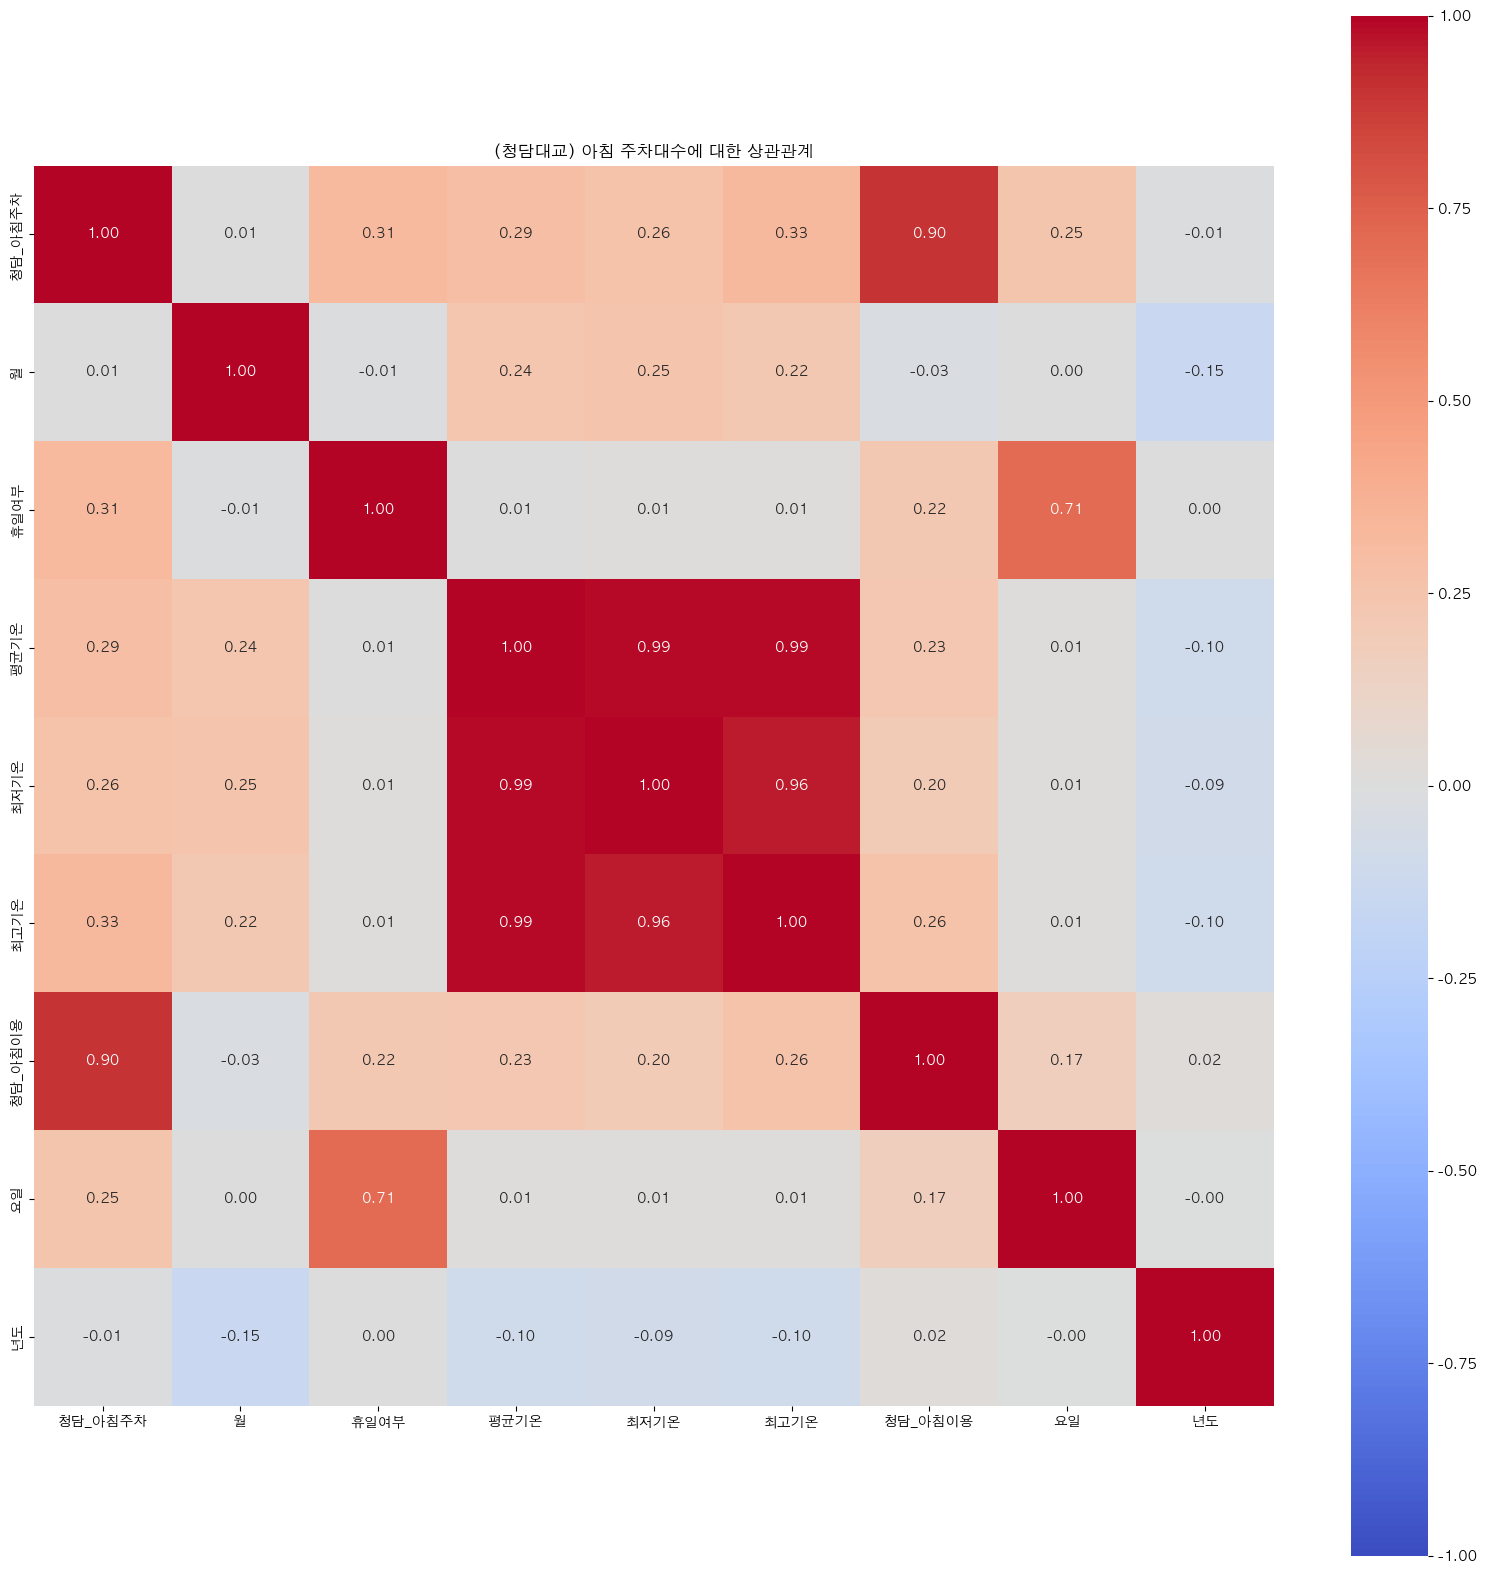

In [150]:

plt.figure(figsize=(20,20))
sns.heatmap(df_C.iloc[:,[6,1,2,3,4,5,9,12,14]].corr(),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            )

plt.title('(청담대교) 아침 주차대수에 대한 상관관계')
plt.show()

> 온도는 한가지만 사용해보자

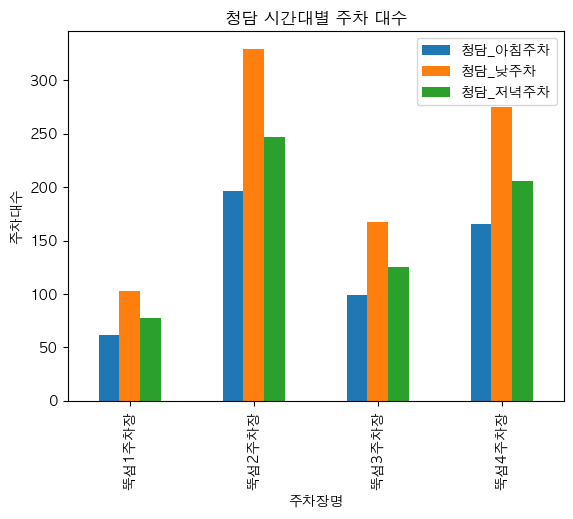

In [90]:

avg_usage = df_C.groupby('주차장명')[['청담_아침주차', '청담_낮주차', '청담_저녁주차']].mean()
avg_usage.plot(kind='bar', title='청담 시간대별 주차 대수')
plt.ylabel('주차대수')
plt.show()


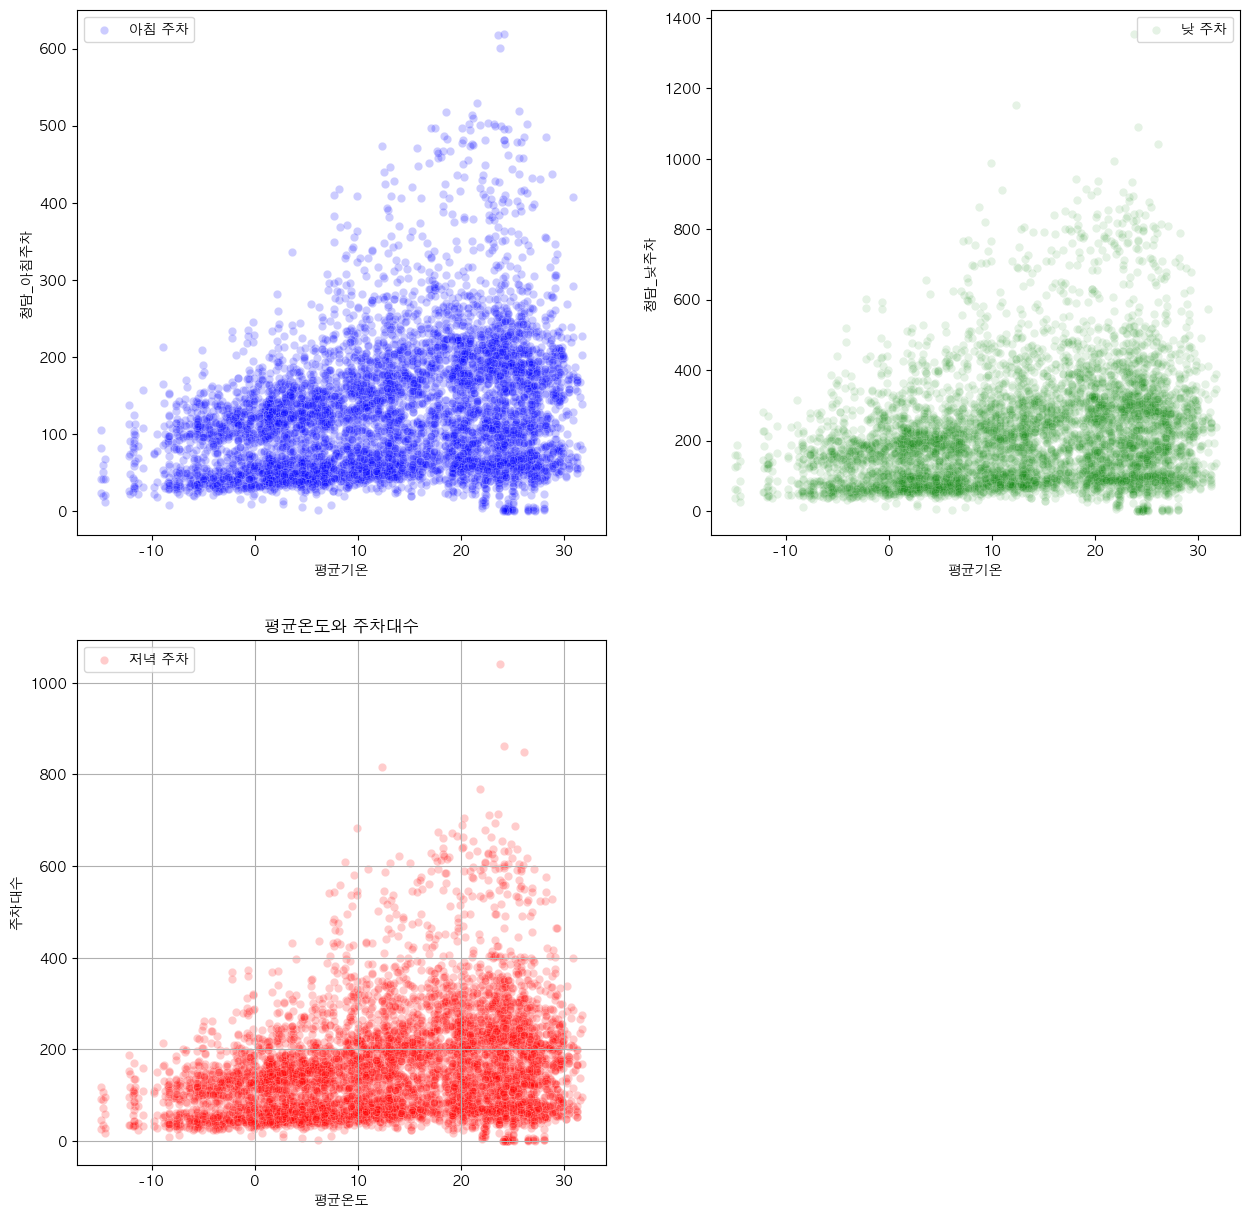

In [ ]:
fig = plt.figure(figsize=(15,15))
ax1= fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
sns.scatterplot(x='평균기온', y='청담_아침주차', data=df_C,color='blue', label='아침 주차', alpha=0.2, ax=ax1)
sns.scatterplot(x='평균기온', y='청담_낮주차', data=df_C,color='green', label='낮 주차', alpha=0.1, ax=ax2)
sns.scatterplot(x='평균기온', y='청담_저녁주차',data=df_C,color='red', label='저녁 주차', alpha=0.2, ax=ax3)
plt.title('평균온도와 주차대수')
plt.xlabel('평균온도')
plt.ylabel('주차대수')
plt.legend()
plt.grid(True)
plt.show()


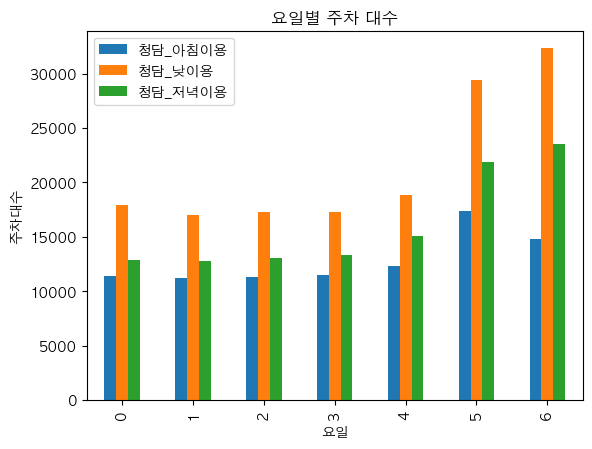

In [95]:

avg_usage = df_C.groupby('요일')[['청담_아침이용', '청담_낮이용', '청담_저녁이용']].mean()
avg_usage.plot(kind='bar', title='요일별 주차 대수')
plt.ylabel('주차대수')
plt.show()


------
## 영동대교 기준 주차대수, 이용자 분리

<Axes: >

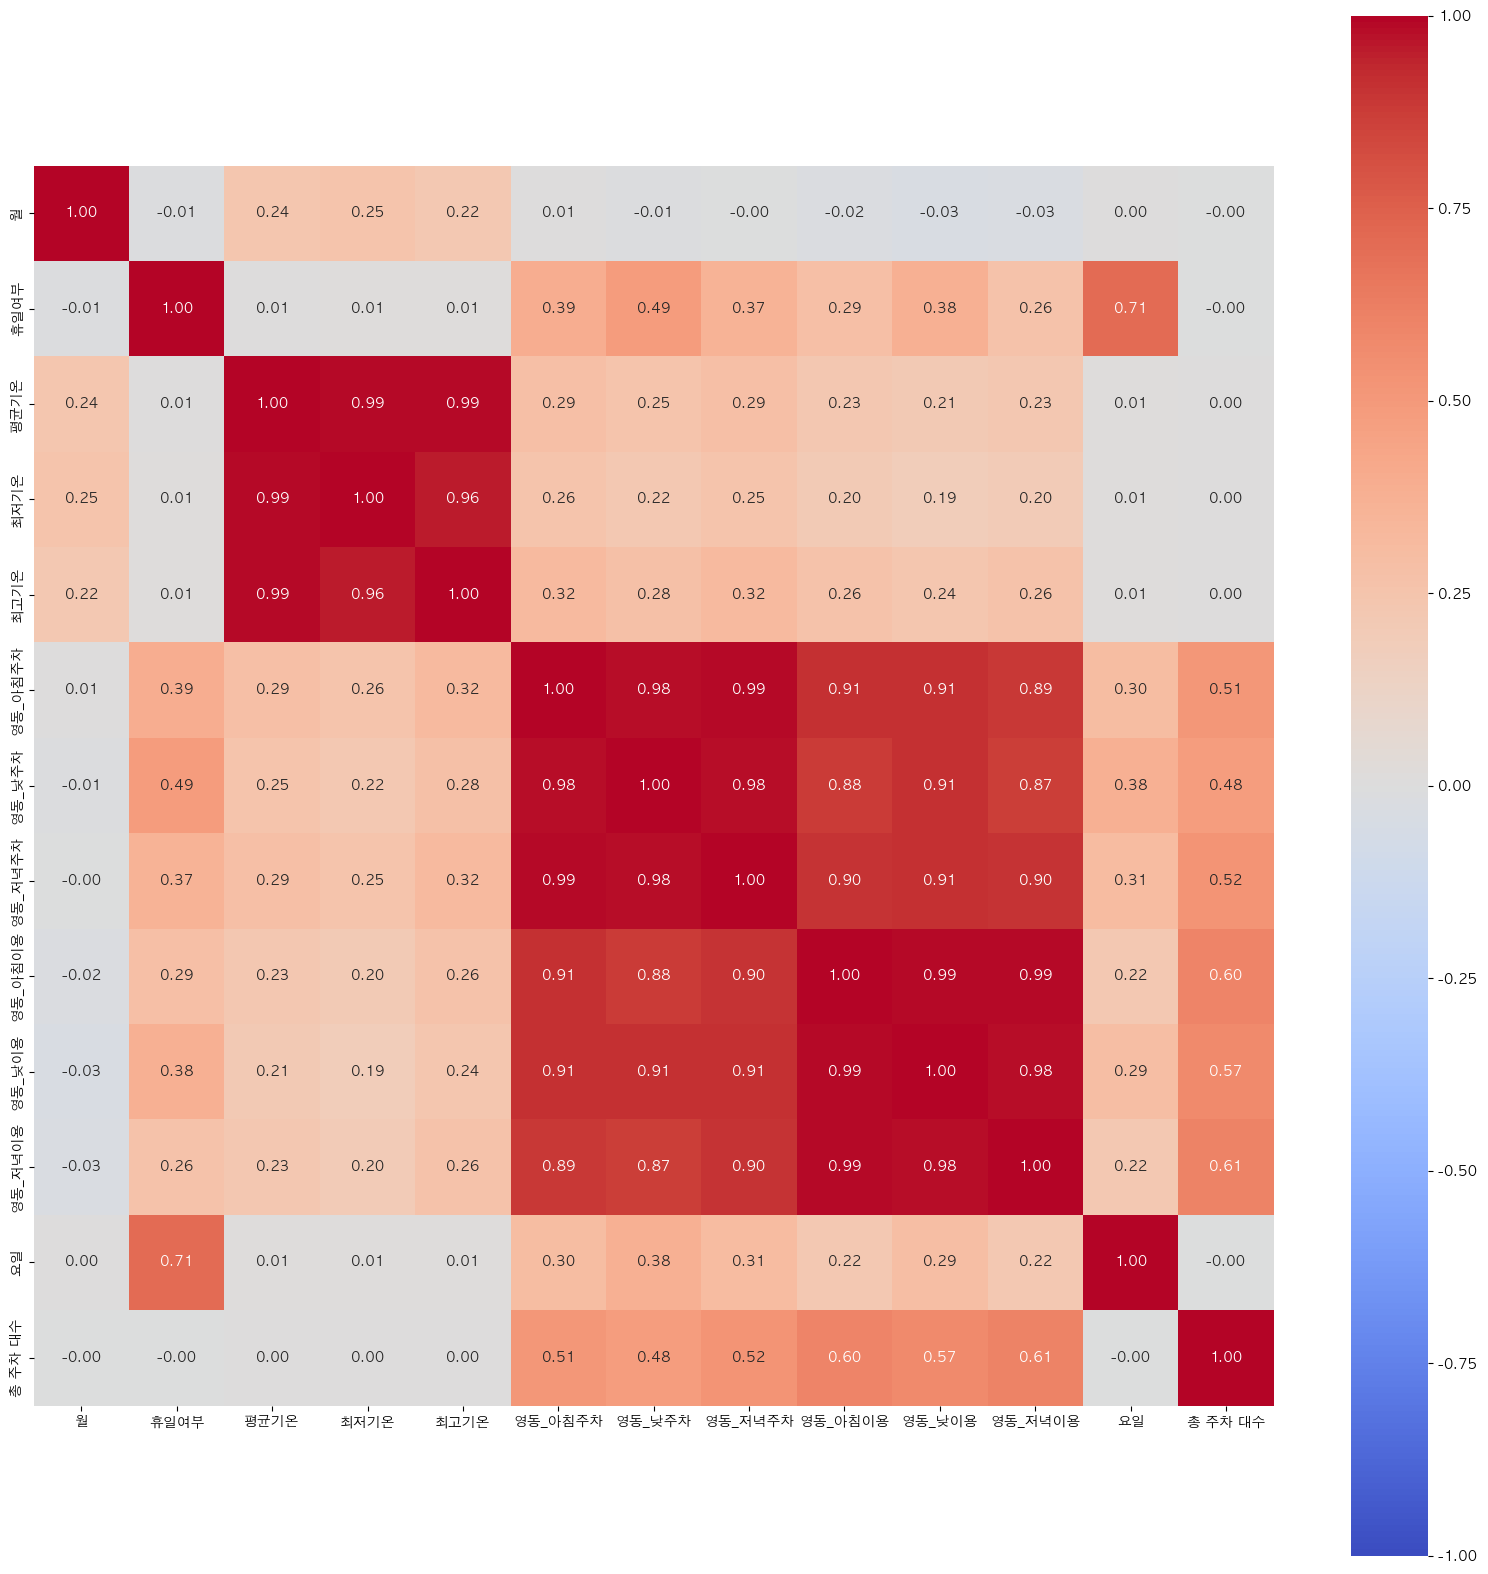

In [142]:

plt.figure(figsize=(20,20))
sns.heatmap(df_Y.iloc[:,1:].corr(),
            annot=True,  # 각 셀에 숫자 표시
            cmap='coolwarm',  # 색상 맵 설정
            vmin=-1, vmax=1,  # 색상 범위 설정
            center=0,  # 0을 중심으로 색상 대칭
            square=True,  # 정사각형 셀
            fmt='.2f', # 소수점 둘째 자리까지 표시
            )

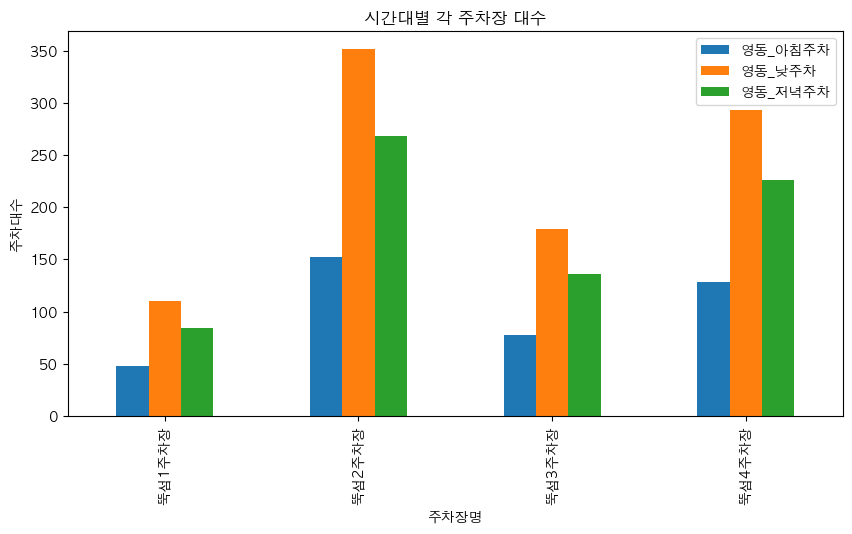

In [143]:
avg_usage = df_Y.groupby('주차장명')[['영동_아침주차', '영동_낮주차', '영동_저녁주차']].mean()
avg_usage.plot(kind='bar', title='시간대별 각 주차장 대수', figsize=(10,5))
plt.ylabel('주차대수')
plt.show()


-----
## 데이터 준비
- 1 : 기온 컬럼 표준화
- 2 : 표준화 X

In [103]:
df_C.columns

Index(['주차장명', '월', '휴일여부', '평균기온', '최저기온', '최고기온', '청담_아침주차', '청담_낮주차',
       '청담_저녁주차', '청담_아침이용', '청담_낮이용', '청담_저녁이용', '요일', '총 주차 대수'],
      dtype='object')

In [274]:
df_C_dummies = pd.get_dummies(df_C[['월','요일','주차장명','휴일여부','년도','최고기온']])

In [275]:
df_C_dummies

,월,요일,휴일여부,년도,최고기온,주차장명_뚝섬1주차장,주차장명_뚝섬2주차장,주차장명_뚝섬3주차장,주차장명_뚝섬4주차장
0,2,3,0,2024,9.6,False,True,False,False
1,2,3,0,2024,9.6,True,False,False,False
2,2,3,0,2024,9.6,False,False,True,False
3,2,3,0,2024,9.6,False,False,False,True
4,2,2,0,2024,10.1,False,False,True,False
...,...,...,...,...,...,...,...,...,...
5935,1,1,0,2020,5.5,False,True,False,False
5936,1,0,0,2020,5.5,False,False,True,False
5937,1,6,1,2020,5.3,False,False,True,False
5938,1,5,1,2020,5.9,False,False,True,False


In [276]:

#  일반 feature
df_C_dummies


# Target 
df_C_Target=df_C[['청담_아침이용','청담_낮이용','청담_저녁이용']]

In [ ]:
# train, Target 분리
cx_train, cx_test, cy_train,cy_test = train_test_split(
                                                    df_C_dummies,
                                                    df_C_Target,
                                                    random_state=42,
                                                    test_size=0.3
)

In [284]:
cx_train

,월,요일,휴일여부,년도,최고기온,주차장명_뚝섬1주차장,주차장명_뚝섬2주차장,주차장명_뚝섬3주차장,주차장명_뚝섬4주차장
2627,5,5,1,2022,23.1,False,False,True,False
5036,9,3,0,2020,27.0,False,True,False,False
4684,12,1,0,2020,4.1,True,False,False,False
5431,5,6,1,2020,28.0,True,False,False,False
3874,6,0,0,2021,29.2,False,False,False,True
...,...,...,...,...,...,...,...,...,...
3772,7,5,1,2021,36.5,True,False,False,False
5191,7,3,0,2020,28.4,False,False,True,False
5226,7,1,0,2020,30.5,False,False,False,True
5390,6,2,0,2020,32.1,True,False,False,False


In [ ]:
# 랜덤포레스트
rf_regressor = RandomForestRegressor()

# MultiOutputRegressor
multi_output_rf = MultiOutputRegressor(rf_regressor)

# 모델 학습
multi_output_rf.fit(cx_train, cy_train)


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [318]:


# 테스트 세트에 대한 예측
cy_pred = multi_output_rf.predict(cx_test)

# 각 출력에 대한 R² 점수 계산
r2_scores = r2_score(cy_test, cy_pred, multioutput='raw_values')

# 각 출력에 대한 MSE 계산
mse_scores = mean_squared_error(cy_test,cy_pred, multioutput='raw_values')

# 각 출력에 대한 RMSE 계산
rmse_scores = np.sqrt(mse_scores)

# 각 출력에 대한 MAE 계산
mae_scores = mean_absolute_error(cy_test, cy_pred, multioutput='raw_values')

# 결과 출력
for i, (r2, mse, rmse, mae) in enumerate(zip(r2_scores, mse_scores, rmse_scores, mae_scores)):
    print(f"Output {i+1}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print()

# 전체 모델의 평균 성능
print("Overall Model Performance:")
print(f"  Average R² Score: {np.mean(r2_scores):.4f}")
print(f"  Average MSE: {np.mean(mse_scores):.4f}")
print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"  Average MAE: {np.mean(mae_scores):.4f}")


Output 1:
  R² Score: 0.7533
  MSE: 23097737.1032
  RMSE: 4806.0105
  MAE: 2943.5455

Output 2:
  R² Score: 0.7705
  MSE: 67075080.3301
  RMSE: 8189.9377
  MAE: 4928.7545

Output 3:
  R² Score: 0.7697
  MSE: 37531166.3947
  RMSE: 6126.2686
  MAE: 3665.1276

Overall Model Performance:
  Average R² Score: 0.7645
  Average MSE: 42567994.6093
  Average RMSE: 6374.0723
  Average MAE: 3845.8092


In [319]:

# 특성 중요도 추출
feature_importance = np.mean([tree.feature_importances_ for tree in multi_output_rf.estimators_], axis=0)

# 특성 이름과 중요도를 데이터프레임으로 만들기
feature_importance_df = pd.DataFrame({
    'feature': cx_train.columns,
    'importance': feature_importance
})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("특성 중요도")
print(feature_importance_df)

특성 중요도
       feature  importance
6  주차장명_뚝섬2주차장    0.287341
4         최고기온    0.272535
2         휴일여부    0.129166
0            월    0.097840
8  주차장명_뚝섬4주차장    0.070665
3           년도    0.063216
1           요일    0.034882
5  주차장명_뚝섬1주차장    0.029556
7  주차장명_뚝섬3주차장    0.014800


-----------------

## 영동대교 기준 데이터 이용시간 예측 모델

In [283]:
df_Y

,주차장명,월,휴일여부,평균기온,최저기온,최고기온,영동_아침주차,영동_낮주차,영동_저녁주차,영동_아침이용,영동_낮이용,영동_저녁이용,요일,총 주차 대수,년도
0,뚝섬2주차장,2,0,4.8,0.3,9.6,97.501291,222.281389,198.217320,10324.219759,23536.938585,20988.841656,3,356,2024
1,뚝섬1주차장,2,0,4.8,0.3,9.6,32.939625,75.095064,66.965311,1900.710504,4333.199742,3864.089755,3,67,2024
2,뚝섬3주차장,2,0,4.8,0.3,9.6,48.938872,111.569809,99.491319,3807.256027,8679.702038,7740.041936,3,112,2024
3,뚝섬4주차장,2,0,4.8,0.3,9.6,99.007103,225.714306,201.278591,10313.114399,23511.620821,20966.264780,3,136,2024
4,뚝섬3주차장,2,0,6.4,3.2,10.1,39.041615,84.172189,71.786196,3496.527013,7538.374930,6429.098057,2,112,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,뚝섬2주차장,1,0,-0.4,-5.6,5.5,23.588702,54.054480,49.356818,5755.457609,13188.867391,12042.675000,1,356,2020
5936,뚝섬3주차장,1,0,0.7,-3.3,5.5,11.059134,25.347544,21.593322,279.910500,641.555069,546.534431,0,112,2020
5937,뚝섬3주차장,1,1,1.9,-0.4,5.3,42.021679,117.752740,82.225582,2470.770520,6923.569136,4834.660344,6,112,2020
5938,뚝섬3주차장,1,1,0.3,-4.1,5.9,47.470482,116.861358,88.668160,3413.183912,8402.470246,6375.345842,5,112,2020


In [288]:
df_Y_dummies = pd.get_dummies(df_Y[['월','요일','주차장명','휴일여부','년도','최고기온']])
df_Y_dummies

,월,요일,휴일여부,년도,최고기온,주차장명_뚝섬1주차장,주차장명_뚝섬2주차장,주차장명_뚝섬3주차장,주차장명_뚝섬4주차장
0,2,3,0,2024,9.6,False,True,False,False
1,2,3,0,2024,9.6,True,False,False,False
2,2,3,0,2024,9.6,False,False,True,False
3,2,3,0,2024,9.6,False,False,False,True
4,2,2,0,2024,10.1,False,False,True,False
...,...,...,...,...,...,...,...,...,...
5935,1,1,0,2020,5.5,False,True,False,False
5936,1,0,0,2020,5.5,False,False,True,False
5937,1,6,1,2020,5.3,False,False,True,False
5938,1,5,1,2020,5.9,False,False,True,False


In [289]:
df_Y_target = df_Y[['영동_아침이용','영동_낮이용','영동_저녁이용']]
df_Y_target

,영동_아침이용,영동_낮이용,영동_저녁이용
0,10324.219759,23536.938585,20988.841656
1,1900.710504,4333.199742,3864.089755
2,3807.256027,8679.702038,7740.041936
3,10313.114399,23511.620821,20966.264780
4,3496.527013,7538.374930,6429.098057
...,...,...,...
5935,5755.457609,13188.867391,12042.675000
5936,279.910500,641.555069,546.534431
5937,2470.770520,6923.569136,4834.660344
5938,3413.183912,8402.470246,6375.345842


In [ ]:
# train, Target 분리
Yx_train, Yx_test, Yy_train,Yy_test = train_test_split(
                                                    df_Y_dummies,
                                                    df_Y_target,
                                                    test_size=0.2
)

In [ ]:
# 랜덤포레스트
rf_regressor = RandomForestRegressor()

# MultiOutputRegressor
multi_output_rf = MultiOutputRegressor(rf_regressor)

# 모델 학습
multi_output_rf.fit(Yx_train, Yy_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [ ]:


# 테스트 세트에 대한 예측
Yy_pred = multi_output_rf.predict(Yx_test)

# 각 출력에 대한 R² 점수 계산
r2_scores = r2_score(Yy_test, Yy_pred, multioutput='raw_values')

# 각 출력에 대한 MSE 계산
mse_scores = mean_squared_error(Yy_test, Yy_pred, multioutput='raw_values')

# 각 출력에 대한 MAE 계산
mae_scores = mean_absolute_error(Yy_test, Yy_pred, multioutput='raw_values')

# 결과 출력
for i, (r2, mse ,mae) in enumerate(zip(r2_scores, mse_scores,mae_scores)):
    print(f" 결과 {i+1}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}\n")

# 전체 모델의 평균 성능
print("성는 평가")
print(f" 평균 R² Score: {np.mean(r2_scores):.4f}")
print(f" 평균 MSE: {np.mean(mse_scores):.4f}")
print(f" 평균 MAE: {np.mean(mae_scores):.4f}")


Output 1:
  R² Score: 0.7685
  MSE: 13649531.2883
  RMSE: 3694.5272
  MAE: 2271.3707

Output 2:
  R² Score: 0.7784
  MSE: 75074522.6669
  RMSE: 8664.5555
  MAE: 5167.8081

Output 3:
  R² Score: 0.7519
  MSE: 44092224.8680
  RMSE: 6640.1977
  MAE: 4071.6346

Overall Model Performance:
  Average R² Score: 0.7662
  Average MSE: 44272092.9410
  Average RMSE: 6333.0935
  Average MAE: 3836.9378


----------------
## 영동대교 VS 청담대교

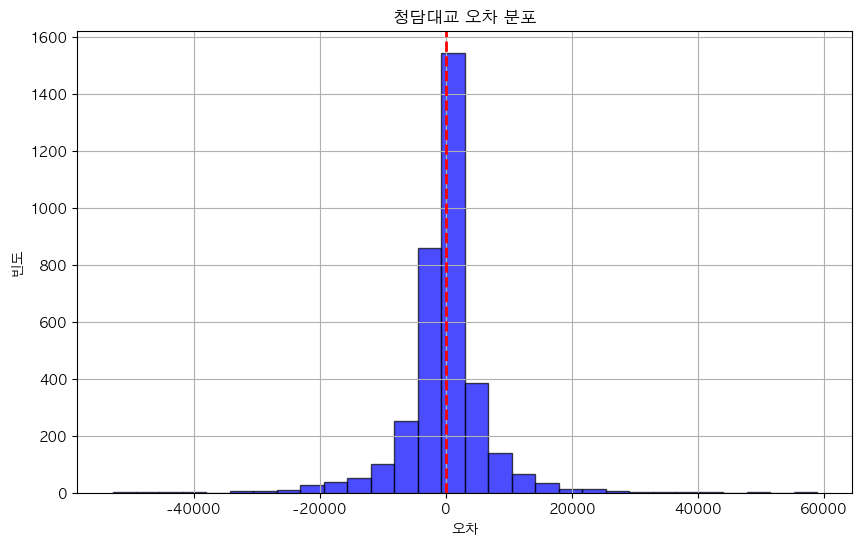

In [334]:
fig = plt.figure(figsize=(10,6))

# 테스트 세트에 대한 실제값과 예측값의 차이(오차) 계산
cerrors = cy_test - cy_pred

# 오차 분포 시각화
plt.hist(cerrors.values.flatten(), bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('청담대교 오차 분포')
plt.xlabel('오차')
plt.ylabel('빈도')
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.grid(True)
plt.show()

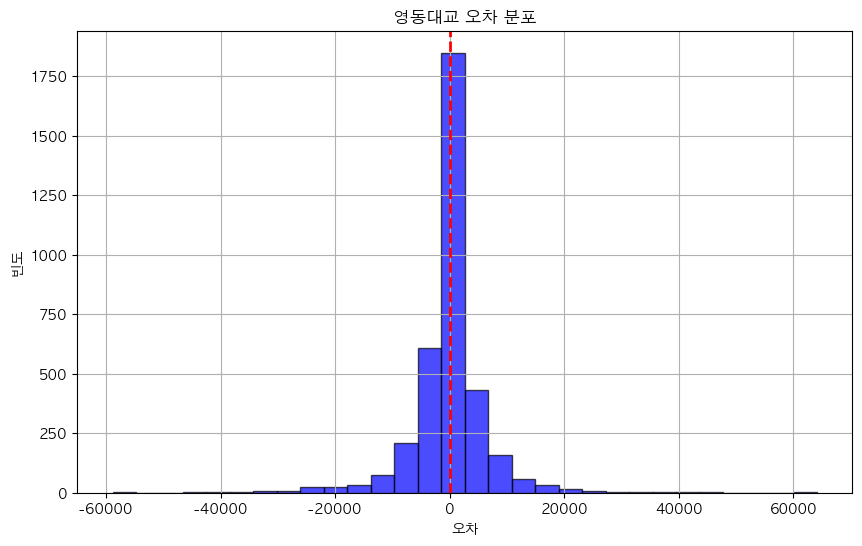

In [336]:
# 테스트 세트에 대한 실제값과 예측값의 차이(오차) 계산
yerrors = Yy_test - Yy_pred

# 오차 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(yerrors.values.flatten(), bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('영동대교 오차 분포')
plt.xlabel('오차')
plt.ylabel('빈도')
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
plt.grid(True)
plt.show()



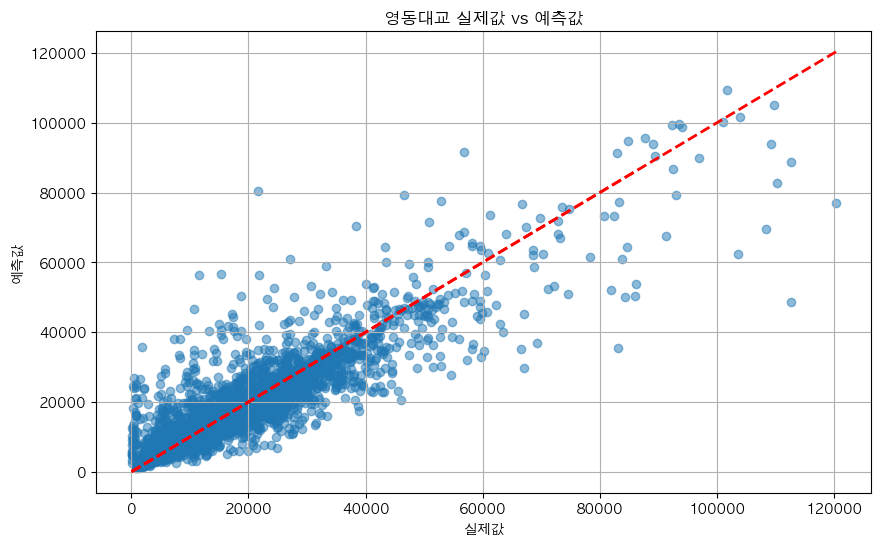

In [339]:
# 실제값 vs 예측값 시각화
plt.figure(figsize=(10, 6))
plt.scatter(Yy_test.values.flatten(), Yy_pred.flatten(), alpha=0.5)
plt.plot([Yy_test.min(), Yy_test.max()], [Yy_test.min(), Yy_test.max()], 'r--', lw=2)
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('영동대교 실제값 vs 예측값')
plt.grid(True)
plt.show()


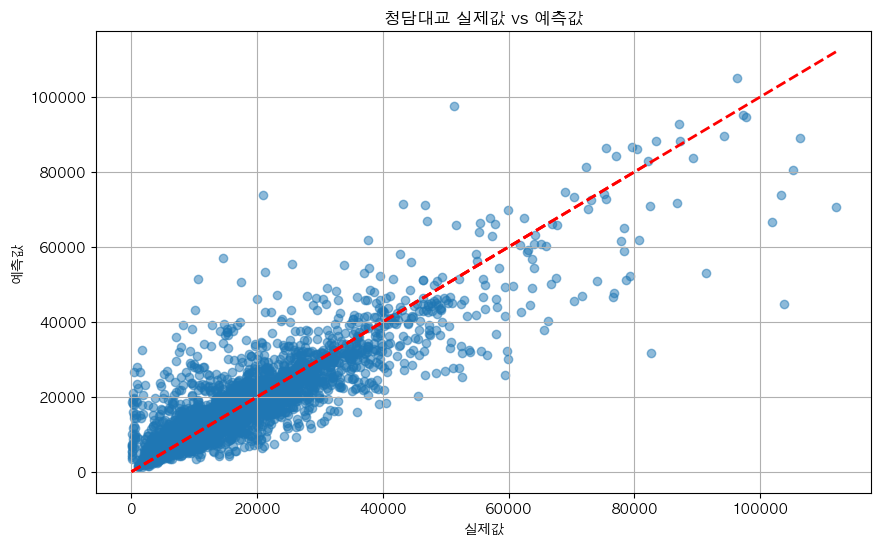

In [338]:
# 실제값 vs 예측값 시각화
plt.figure(figsize=(10, 6))
plt.scatter(cy_test.values.flatten(), cy_pred.flatten(), alpha=0.5)
plt.plot([cy_test.min(), cy_test.max()], [cy_test.min(), cy_test.max()], 'r--', lw=2)
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('청담대교 실제값 vs 예측값')
plt.grid(True)
plt.show()

> 영동대교 기준으로 나눈 데이터를 선택하는 것이 좋아보임

--------------
- 여유: 예측 주차대수 ≤ 50% * 주차구획수
- 보통: 50% < 예측 주차대수 ≤ 80% * 주차구획수
- 혼잡: 80% < 예측 주차대수 ≤ 100% * 주차구획수
- 만차: 예측 주차대수 > 100% * 주차구획수

# 그리드 서치

In [362]:
# 랜덤포레스트 Hyper Parameter
RandomForestparams = {
    'n_estimators': [100, 200, 500, 700],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [ ]:


# 랜덤포레스트 그리드 서치

gs = GridSearchCV(
    RandomForestRegressor(),
    param_grid=RandomForestparams, 
    n_jobs=-2,
    
    )


gs.fit(Yx_train,Yy_train )

# 최적값 적용
dt = gs.best_estimator_
print(f'train score {dt.score(Yx_train,Yy_train)}')

# 최적의 값 확인
print(f'best parmeter {gs.best_params_}')


train score 0.9063607759350473
test score 0.7778316781548357
best parmeter {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [455]:
dtscores = cross_validate(dt, Yx_train, Yy_train, cv=5,return_train_score=True)
print(np.mean(dtscores['train_score']), np.mean(dtscores['test_score']))

0.9057204120971025 0.7540844957112129


    RandomForest 
    max_depth : 20
    max_feature : log2
    min_sample_leaf : 1
    min_samples_split :5
    n_estimators :200
    train : 90
    test : 77
    

In [394]:

# SVM parameter
SVMparams = {
    'kernel': ['linear', 'poly'],
    # 'kernel': ['linear'],
    'C': [100],
    'epsilon': [3000,6000,9000],
    # 'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)) # 10^-3부터 10^3까지 7개 생성
}


# 추가
# degree : 다항식커널(poly)사용 할 때 다항식의 차수 지정
# coef :  poly, sigmoid 커널에서 사용 가능 bias의 영향을 제어

In [ ]:



# SVM 그리드 서치
gs = GridSearchCV(
    MultiOutputRegressor(SVR()),
    param_grid={'estimator__' + key: value for key, value in SVMparams.items()},
    n_jobs=-2,
    )


gs.fit(Yx_train,Yy_train )

# 최적값 적용
svm= gs.best_estimator_
print(f'train score {svm.score(Yx_train,Yy_train)}')

# 최적의 값 확인


train score 0.5231484535874426
test score 0.5189849723650694
best parmeter {'estimator__C': 100, 'estimator__epsilon': 3000, 'estimator__kernel': 'linear'}


In [454]:
svmscore = cross_validate(
    svm,
    Yx_train,
    Yy_train,
    cv=5,
    return_train_score=True
    
)
print(np.mean(svmscore['train_score']), np.mean(svmscore['test_score']))

0.5222933068264248 0.5209868696867668


> SVM 못씀          
    c = 100
    epsilon : 300
    kernel : linear

In [448]:
xgbParms = {
    'max_depth': [3,4,5,6,7],
    'min_child_weight': [0.5,1,2,3],
    # 'subsample': [0.6, 0.8],
    # 'colsample_bytree': [0.6, 0.8],
    'learning_rate': [0.05,0.1,0.03],
    'n_estimators': [100,500, 300 , 700],
    # 'estimator__reg_alpha': [0.1],
    # 'estimator__reg_lambda': [1]
}

In [ ]:
# XGBoost
gs = GridSearchCV(
    MultiOutputRegressor(XGBRegressor()),
    param_grid={'estimator__' + key: value for key, value in xgbParms.items()},
    n_jobs=-2,
    )
gs.fit(Yx_train,Yy_train )
xgb= gs.best_estimator_


In [ ]:
print(f'best parameter{gs.best_params_}')
# 최적의 파라미터
# learning_rate = 0.1, 
# max_depth = 6
# min_child_weight = 0.5
# n_estimators = 700

best parameter{'estimator__learning_rate': 0.1, 'estimator__max_depth': 6, 'estimator__min_child_weight': 0.5, 'estimator__n_estimators': 700}


In [456]:
scores  = cross_validate(xgb ,Yx_train, Yy_train, cv=5,n_jobs=-1, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

0.9882873779787152 0.8297850238671238


> XGBoost 성능이 좋아 보임  ==> 과대적합을 해소하자?

---------------------------------------

In [6]:
import pandas as pd

In [2]:
df_Y = pd.read_csv('../../Data/뚝섬 한강공원 주차대수 예측.csv')

In [3]:
df_Y.columns

Index(['주차장명', '월', '휴일여부', '최고기온', '영동_아침주차', '영동_낮주차', '영동_저녁주차', '영동_아침이용',
       '영동_낮이용', '영동_저녁이용', '요일', '주차구획수', '연도'],
      dtype='object')

In [16]:
df_Y = pd.read_csv('../../Data/뚝섬테이블(영동대교).csv')

### 체크포인트

In [ ]:
features=['월','요일','주차장명','휴일여부','년도','최고기온']
target_usage = ['영동_아침이용','영동_낮이용','영동_저녁이용']
parking_Target = ['영동_아침주차','영동_낮주차','영동_저녁주차']

# 이용시간 feature
X = pd.get_dummies(df_Y[features])

# 이용시간 Taret
y_usage = df_Y[target_usage]

# 주차대수 Target
y_parking = df_Y[parking_Target]


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y_usage, test_size=0.2)

# 모델 학습
usage_model = MultiOutputRegressor(XGBRegressor(max_depth=6,learning_rate=0.1,min_child_weight=0.5,n_estimators=700))
usage_model.fit(X_train, y_train)

# 예측
predicted_usage = usage_model.predict(X_test)

# 훈련 및 테스트 점수 출력
train_score_usage = usage_model.score(X_train, y_train)
test_score_usage = usage_model.score(X_test, y_test)

print(f"이용시간 예측 모델 - 훈련 점수: {train_score_usage:.2f}")
print(f"이용시간 예측 모델 - 테스트 점수: {test_score_usage:.2f}")

이용시간 예측 모델 - 훈련 점수: 0.98
이용시간 예측 모델 - 테스트 점수: 0.84


In [13]:
X_test.columns

Index(['월', '요일', '휴일여부', '년도', '최고기온', '주차장명_뚝섬1주차장', '주차장명_뚝섬2주차장',
       '주차장명_뚝섬3주차장', '주차장명_뚝섬4주차장'],
      dtype='object')

In [21]:
from sklearn.multioutput import MultiOutputRegressor

# 예측된 이용시간 추가
df_Y[['아침 이용시간 예측','낮 이용시간 예측','저녁 이용시간 예측']] = usage_model.predict(X)

# 새로운 입력 피처 설정
features_with_usage = ['아침 이용시간 예측','낮 이용시간 예측','저녁 이용시간 예측'] + features
X_parking = pd.get_dummies(df_Y[features_with_usage])

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_parking, y_parking, test_size=0.2)

# MultiOutputRegressor로 학습
parking_model = MultiOutputRegressor(XGBRegressor(max_depth=6,learning_rate=0.1,min_child_weight=0.5,n_estimators=700))
parking_model.fit(X_train, y_train)

# 예측
predicted_parking = parking_model.predict(X_test)

# 훈련 및 테스트 점수 출력
train_score_parking = parking_model.score(X_train, y_train)
test_score_parking = parking_model.score(X_test, y_test)

print(f"시간대별 주차대수 예측 모델 - 훈련 점수: {train_score_parking:.2f}")
print(f"시간대별 주차대수 예측 모델 - 테스트 점수: {test_score_parking:.2f}")


시간대별 주차대수 예측 모델 - 훈련 점수: 0.99
시간대별 주차대수 예측 모델 - 테스트 점수: 0.91


In [22]:
X_train

아침 이용시간 예측     낮 이용시간 예측    저녁 이용시간 예측   월  요일  휴일여부    년도  최고기온  \
2330  13732.916992  30345.757812  27512.560547   7   2     0  2022  30.4   
4833   7971.897461  18622.164062  12739.976562  10   5     1  2020  18.2   
1413  37062.027344  84752.117188  60941.277344   3   5     1  2023  22.8   
1483  11508.350586  25862.791016  21903.246094   2   2     0  2023   8.4   
2075  10405.660156  21412.332031  17591.556641   9   5     1  2022  24.2   
...            ...           ...           ...  ..  ..   ...   ...   ...   
829   15290.100586  38513.074219  27208.599609   8   6     1  2023  33.0   
4195   8499.668945  17762.656250  15132.150391   4   4     0  2021  19.6   
2323   8488.112305  17604.390625  15845.219727   7   4     0  2022  27.5   
1833   5452.458984  11624.005859   8576.416016  11   5     1  2022  12.9   
1706  11783.701172  25633.191406  21859.144531  12   2     0  2022   0.1   

      주차장명_뚝섬1주차장  주차장명_뚝섬2주차장  주차장명_뚝섬3주차장  주차장명_뚝섬4주차장  
2330        False         True        False        False  
4833        False        False         True        False  
1413        False         True        False        False  
1483        False         True        False        False  
2075         True        False        False        False  
...           ...          ...          ...          ...  
829         False        False        False         True  
4195        False        False         True        False  
2323        False        False         True        False  
1833         True        False        False        False  
1706        False         True        False        False  

[4752 rows x 12 columns]

In [23]:
X_train
# y_train

,아침 이용시간 예측,낮 이용시간 예측,저녁 이용시간 예측,월,요일,휴일여부,년도,최고기온,주차장명_뚝섬1주차장,주차장명_뚝섬2주차장,주차장명_뚝섬3주차장,주차장명_뚝섬4주차장
2330,13732.916992,30345.757812,27512.560547,7,2,0,2022,30.4,False,True,False,False
4833,7971.897461,18622.164062,12739.976562,10,5,1,2020,18.2,False,False,True,False
1413,37062.027344,84752.117188,60941.277344,3,5,1,2023,22.8,False,True,False,False
1483,11508.350586,25862.791016,21903.246094,2,2,0,2023,8.4,False,True,False,False
2075,10405.660156,21412.332031,17591.556641,9,5,1,2022,24.2,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
829,15290.100586,38513.074219,27208.599609,8,6,1,2023,33.0,False,False,False,True
4195,8499.668945,17762.656250,15132.150391,4,4,0,2021,19.6,False,False,True,False
2323,8488.112305,17604.390625,15845.219727,7,4,0,2022,27.5,False,False,True,False
1833,5452.458984,11624.005859,8576.416016,11,5,1,2022,12.9,True,False,False,False


In [24]:
# 혼잡도 계산 함수
def calculate_congestion(parking_count, capacity):
    ratio = parking_count / capacity
    if ratio <= 0.5:
        return '여유'
    elif ratio <= 0.8:
        return '보통'
    elif ratio <= 1.0:
        return '혼잡'
    else:
        return '만차'

# 예측
predicted_parking_full = parking_model.predict(X_parking)

# 혼잡도 계산
for time, idx in zip(['아침', '낮', '저녁'], range(3)):
    df_Y[f'{time} 혼잡도'] = [
        calculate_congestion(p, c) 
        for p, c in zip(predicted_parking_full[:, idx], df_Y['총 주차 대수'])
    ]

# 결과 확인
result = df_Y[['주차장명','아침 혼잡도', '낮 혼잡도', '저녁 혼잡도','아침 이용시간 예측', '낮 이용시간 예측', '저녁 이용시간 예측']]
print(result.head())

     주차장명 아침 혼잡도 낮 혼잡도 저녁 혼잡도    아침 이용시간 예측     낮 이용시간 예측    저녁 이용시간 예측
0  뚝섬2주차장     여유    여유     여유  10768.382812  24464.019531  21245.265625
1  뚝섬1주차장     여유    만차     혼잡   2118.292969   4152.757324   4359.835449
2  뚝섬3주차장     여유    혼잡     보통   3584.508789   7862.086914   6939.142090
3  뚝섬4주차장     보통    만차     만차  10712.555664  21985.117188  20015.333984
4  뚝섬3주차장     여유    보통     보통   3513.385986   7686.164551   6854.256348


In [1]:
import pandas as pd
import joblib
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

# 1. 데이터 준비
# 입력 피처와 타겟 변수 설정
features = ['월', '요일', '주차장명', '휴일여부', '연도', '최고기온']  # 입력 피처
target_usage = ['영동_아침이용', '영동_낮이용', '영동_저녁이용']       # 이용시간 타겟
parking_Target = ['영동_아침주차', '영동_낮주차', '영동_저녁주차']   # 주차대수 타겟

# 범주형 데이터를 원-핫 인코딩하여 모델 입력으로 변환
X = pd.get_dummies(df_Y[features])       # 이용시간 예측용 입력 피처
y_usage = df_Y[target_usage]            # 이용시간 타겟
y_parking = df_Y[parking_Target]        # 주차대수 타겟

#########################################################################################################################################
#### ** 이용시간 예측 모델 학습 및 저장 *** ####
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y_usage, test_size=0.2)

# 이용시간 모델 학습
usage_model = MultiOutputRegressor(
    XGBRegressor(max_depth=6, learning_rate=0.1, min_child_weight=0.5, n_estimators=700)
)
usage_model.fit(X_train, y_train)

# 예측 및 점수 출력
train_score_usage = usage_model.score(X_train, y_train)  # 훈련 데이터 점수
test_score_usage = usage_model.score(X_test, y_test)     # 테스트 데이터 점수
print(f"이용시간 예측 모델 - 훈련 점수: {train_score_usage:.4f}")
print(f"이용시간 예측 모델 - 테스트 점수: {test_score_usage:.4f}")

# 모델 저장
joblib.dump(usage_model, 'Ttuksome_usage_model.pkl')  # 이용시간 모델 저장

#########################################################################################################################################
#### ** 주차대수 예측 모델 학습 및 저장 *** ####
# 이용시간 예측 결과를 새로운 피처로 추가
df_Y[['아침 이용시간 예측', '낮 이용시간 예측', '저녁 이용시간 예측']] = usage_model.predict(X)

# 주차대수 모델 입력 데이터 준비 (예측된 이용시간 추가)
features_with_usage = ['아침 이용시간 예측', '낮 이용시간 예측', '저녁 이용시간 예측'] + features
X_parking = pd.get_dummies(df_Y[features_with_usage])

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_parking, y_parking, test_size=0.2)

# 주차대수 모델 학습
parking_model = MultiOutputRegressor(
    XGBRegressor(max_depth=6, learning_rate=0.1, min_child_weight=0.5, n_estimators=700)
)
parking_model.fit(X_train, y_train)

# 예측 및 점수 출력
train_score_parking = parking_model.score(X_train, y_train)  # 훈련 데이터 점수
test_score_parking = parking_model.score(X_test, y_test)     # 테스트 데이터 점수
print(f"시간대별 주차대수 예측 모델 - 훈련 점수: {train_score_parking:.4f}")
print(f"시간대별 주차대수 예측 모델 - 테스트 점수: {test_score_parking:.4f}")

# 모델 저장
joblib.dump(parking_model, 'Ttuksome_parking_model.pkl')  # 주차대수 모델 저장

#########################################################################################################################################
#### ** 혼잡도 계산 및 결과 저장 *** ####
# 혼잡도 계산 함수 정의
def calculate_congestion(parking_count, capacity):
    """
    주차대수를 기반으로 혼잡도를 계산합니다.
    :param parking_count: 예측된 주차대수
    :param capacity: 주차장의 최대 용량
    :return: 혼잡도 ('여유', '보통', '혼잡', '만차')
    """
    ratio = parking_count / capacity
    if ratio <= 0.5:
        return '여유'  # 50% 이하
    elif ratio <= 0.8:
        return '보통'  # 50~80%
    elif ratio <= 1.0:
        return '혼잡'  # 80~100%
    else:
        return '만차'  # 100% 초과

# 전체 데이터에서 예측된 주차대수 계산
predicted_parking_full = parking_model.predict(X_parking)

# 혼잡도 계산 및 결과 저장
for time, idx in zip(['아침', '낮', '저녁'], range(3)):
    df_Y[f'{time} 혼잡도'] = [
        calculate_congestion(p, c)
        for p, c in zip(predicted_parking_full[:, idx], df_Y['주차구획수'])
    ]

# 최종 결과 출력
result = df_Y[['주차장명', '아침 혼잡도', '낮 혼잡도', '저녁 혼잡도', '아침 이용시간 예측', '낮 이용시간 예측', '저녁 이용시간 예측']]
print(result.head())


NameError: name 'df_Y' is not defined

---

In [25]:
scores = cross_validate(
                    MultiOutputRegressor(XGBRegressor(max_depth=6,learning_rate=0.1,min_child_weight=0.5,n_estimators=700)),
                    X_train,
                    y_train,
                    cv=5,
                    return_train_score=True
)

print(np.mean(scores['test_score']))
print(np.mean(scores['train_score']))
# scores

0.8937645588007065


--------------------
### 2024. 11.20 17시 테스트

In [712]:
usage_model

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=0.5, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=700, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [713]:
['아침 이용시간 예측', '낮 이용시간 예측', '저녁 이용시간 예측', '월', '요일', '휴일여부', '년도','최고기온', '주차장명_뚝섬1주차장', '주차장명_뚝섬2주차장', '주차장명_뚝섬3주차장', '주차장명_뚝섬4주차장']

['아침 이용시간 예측',
 '낮 이용시간 예측',
 '저녁 이용시간 예측',
 '월',
 '요일',
 '휴일여부',
 '년도',
 '최고기온',
 '주차장명_뚝섬1주차장',
 '주차장명_뚝섬2주차장',
 '주차장명_뚝섬3주차장',
 '주차장명_뚝섬4주차장']

In [40]:
test=[11,3,0,2024,12,True,False,False,False]

In [41]:
u_test=usage_model.predict([test])

In [42]:
combine=np.concatenate((u_test,np.array(test).reshape(1,-1)), axis=1)
combine.shape

(1, 12)

In [43]:
print(parking_model.predict(combine))

[[26.435478 58.587395 49.083088]]
